# Import libraries

In [1]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
#!pip install openpyxl

In [2]:
import os
import sys
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.metadata.SignalMetadata import SignalMetadata
from lhcsmapi.pyedsl.dbsignal.post_mortem.PmDbRequest import PmDbRequest
from lhcsmapi.analysis.RbCircuitQuery import RbCircuitQuery

from src.acquisitions.current_voltage_diode_leads_nxcals import CURRENT_VOLTAGE_DIODE_LEADS_NXCALS
from src.acquisitions.current_voltage_diode_leads_pm import CURRENT_VOLTAGE_DIODE_LEADS_PM
from src.acquisitions.ee_t_res_pm import EE_T_RES_PM
from src.acquisitions.ee_u_dump_res_pm import EE_U_DUMP_RES_PM
from src.acquisitions.leads import LEADS
from src.acquisitions.pc_pm import PC_PM
from src.acquisitions.qh_pm import QH_PM
from src.acquisitions.voltage_logic_iqps import VOLTAGE_LOGIC_IQPS
from src.acquisitions.voltage_logic_nqps import VOLTAGE_LOGIC_NQPS
from src.acquisitions.voltage_nxcals import VOLTAGE_NXCALS

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

# Read the (clean) MP3 file

In [3]:
mp3_fpa_df_raw = pd.read_excel("./RB_TC_extract_2021_11_22.xlsx")
len(mp3_fpa_df_raw)

4409

In [4]:
# First row contains units, 9 rows contain only "Before Notebooks" and "After Notebooks" information, which need to be droped
mp3_fpa_df = mp3_fpa_df_raw.dropna(subset = ['Date (FGC)', 'Circuit Name'])
mp3_fpa_df_raw.iloc[~mp3_fpa_df_raw.index.isin(mp3_fpa_df.index)] #show droped rows

,Circuit Name,Circuit Family,Period,Date (FGC),Time (FGC),FPA Reason,Timestamp_PIC,Delta_t(FGC-PIC),Delta_t(EE_even-PIC),Delta_t(EE_odd-PIC),...,Outer cable type,I_Q_SM18,dI_Q_Acc,dI_Q_LHC,Comment,Analysis performed by,lhcsmapi version,lhcsm notebook version,Unnamed: 46,Unnamed: 47
0,NaN,RB,NaN,2008-04-01 00:00:00,13:14:15,NaN,NaN,[ms],[ms],[ms],...,NaN,[A],[A],[A],NaN,NaN,NaN,NaN,NaN,NaN
1,RB.A12,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
169,RB.A23,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
264,RB.A34,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
545,RB.A45,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
897,RB.A56,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
1146,RB.A67,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
1268,RB.A78,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
1430,RB.A81,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
1581,NaN,RB,After Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,After Notebooks,NaN,NaN,NaN


# Find FGC timestamp for each FPA event in MP3 excel

In [5]:
def find_real_fgc_timestamp(circuit_name, fgc_datetime):
    
    fgc_timestamp = Time.to_unix_timestamp(fgc_datetime)
    metadata_fgc = SignalMetadata.get_circuit_signal_database_metadata(
            'RB', circuit_name, 'PC', 'PM', timestamp_query=fgc_timestamp)

    one_sec_in_ns = 1e9 
    start_time = fgc_timestamp - one_sec_in_ns
    end_time = fgc_timestamp + one_sec_in_ns
 
    source_timestamp_fgc = PmDbRequest.find_events(metadata_fgc['source'],
                                                   metadata_fgc['system'],
                                                   metadata_fgc['className'],
                                                   t_start=start_time,
                                                   t_end=end_time)

    return [(circuit_name, el[1]) for el in source_timestamp_fgc]

# getting the list of timestamps
def get_fgc_timestamp(d):
    date_time_str = f"{d['Date (FGC)']} {d['Time (FGC)']}".replace("00:00:00 ","")
    real_fgc_timestamps = find_real_fgc_timestamp(d['Circuit Name'], date_time_str)
    if len(real_fgc_timestamps) > 1:
        print(f"Found more than one event for timestamp {date_time_str}")
    elif not real_fgc_timestamps:
        print(f"Found no event for timestamp {date_time_str}")
        return None
    _, real_fgc_timestamp = real_fgc_timestamps[0]
    return int(real_fgc_timestamp)

In [6]:
mp3_fpa_df['timestamp_fgc'] = mp3_fpa_df.apply(get_fgc_timestamp, axis=1)

Found no event for timestamp 2008-08-19 12:13:28
Found no event for timestamp 2008-08-19 18:53:12
Found no event for timestamp 2008-08-19 20:15:07
Found no event for timestamp 2008-08-19 20:15:07
Found no event for timestamp 2008-08-20 18:41:36
Found no event for timestamp 2008-08-22 09:59:25
Found no event for timestamp 2008-08-22 09:59:25
Found no event for timestamp 2008-08-22 09:59:25
Found no event for timestamp 2008-07-08 08:30:10
Found no event for timestamp 2008-07-08 14:39:16
Found no event for timestamp 2008-07-09 17:14:45
Found no event for timestamp 2008-07-11 14:42:00
Found no event for timestamp 2008-07-15 21:20:30
Found no event for timestamp 2008-07-15 21:20:30
Found no event for timestamp 2008-07-15 21:20:30
Found no event for timestamp 2008-07-15 21:20:30
Found no event for timestamp 2008-07-15 21:20:30
Found no event for timestamp 2008-08-09 02:19:48
Found no event for timestamp 2008-09-07 17:34:03
Found no event for timestamp 2009-12-04 11:19:48
Found no event for t

Found no event for timestamp 2008-04-28 17:08:50
Found no event for timestamp 2008-04-28 17:08:50
Found no event for timestamp 2008-04-29 16:42:45
Found no event for timestamp 2008-04-29 16:42:45
Found no event for timestamp 2008-04-29 16:42:45
Found no event for timestamp 2008-04-29 16:42:45
Found no event for timestamp 2008-04-30 09:02:32
Found no event for timestamp 2008-04-30 09:02:32
Found no event for timestamp 2008-04-30 09:02:32
Found no event for timestamp 2008-04-30 09:02:32
Found no event for timestamp 2008-04-30 09:02:32
Found no event for timestamp 2008-05-06 18:12:16
Found no event for timestamp 2008-05-06 18:12:16
Found no event for timestamp 2008-05-06 18:12:16
Found no event for timestamp 2008-05-06 18:12:16
Found no event for timestamp 2008-05-07 17:53:50
Found no event for timestamp 2008-05-07 17:53:50
Found no event for timestamp 2008-05-07 17:53:50
Found no event for timestamp 2008-05-07 17:53:50
Found no event for timestamp 2008-05-07 17:53:50
Found no event for t

Found no event for timestamp 2015-12-03 09:52:07
Found no event for timestamp 2015-12-03 09:52:07
Found no event for timestamp 2015-12-03 09:52:07
Found no event for timestamp 2008-06-30 11:40:04
Found no event for timestamp 2008-06-30 15:39:44
Found no event for timestamp 2008-07-01 09:58:44
Found no event for timestamp 2008-07-01 09:58:44
Found no event for timestamp 2008-07-01 09:58:44
Found no event for timestamp 2008-07-01 09:58:44
Found no event for timestamp 2008-07-01 09:58:44
Found no event for timestamp 2008-07-01 09:58:44
Found no event for timestamp 2021-05-22 00:43:20.100000
Found no event for timestamp 2021-05-22 00:43:20.100000
Found no event for timestamp 2021-05-22 00:43:20.100000
Found no event for timestamp 2021-05-22 00:43:20.100000
Found no event for timestamp 2021-05-22 00:43:20.100000
Found no event for timestamp 2021-05-22 00:43:20.100000
Found no event for timestamp 2021-05-22 00:58:40.300000
Found no event for timestamp 2021-05-22 00:58:40.300000
Found no even


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Filter mp3 file

In [7]:
# dropping duplicates of timestamps
print(f"{len(mp3_fpa_df['timestamp_fgc'])} mp3 excel file entries")
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['timestamp_fgc', 'Circuit Name']) ### you need timestamp + circuit !!! 

print(f"{len(mp3_fpa_df_unique)} unique fgc events") # 841 Primary quenches?
print(f"{len(mp3_fpa_df[mp3_fpa_df['Nr in Q event']==1])} mp3 primary quench entries") # 834 primary quenches with correct notes

4399 mp3 excel file entries
841 unique fgc events
918 mp3 primary quench entries


In [8]:
operation_periods =[
    'HWC 2007', 
    'HWC 2008', 
    'HWC 2009',
    'HWC 2010', 
    'HWC Oct 2014', 
    'HWC Dec 2014', 
    'HWC 2015', 
    'Operation 2015', 
    'HWC 2016',
    'Operation 2016',
    'HWC Dec 2016', 
    'HWC 2017', 
    'Operation 2017', 
    'Operation 2018',
    'HWC Dec 2018',
    'HWC 2021', 
]

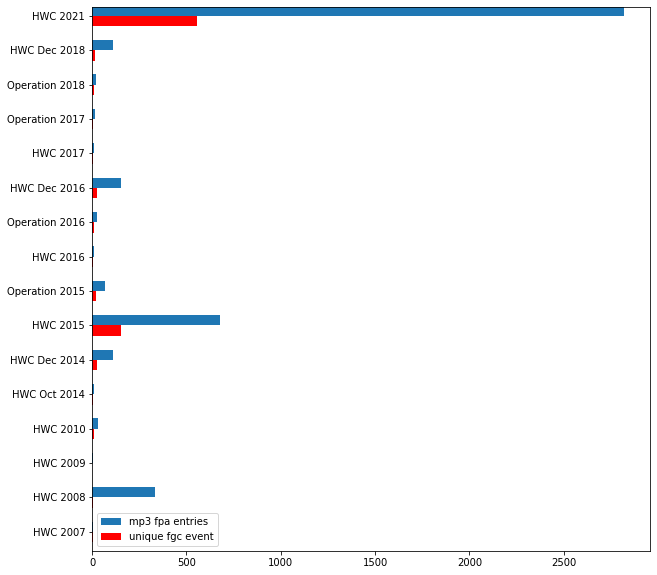

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
width=0.3
mp3_fpa_df.Period.value_counts()[operation_periods].plot(ax=ax, kind='barh', width=width, position=0, label='mp3 fpa entries')
mp3_fpa_df_unique.Period.value_counts()[operation_periods].plot(ax=ax, kind='barh', width=width, position=1, color='red', label='unique fgc event')
#mp3_fpa_df[mp3_fpa_df['Nr in Q event']==1].Period.value_counts()[operation_periods].plot(ax=ax, kind='barh', width=width, position=2, color='orange', label='unique fgc event')
plt.legend()

In [10]:
# mp3 primary quench entries with no unique fgc entry
mp3_fpa_df_missing = mp3_fpa_df[mp3_fpa_df['Nr in Q event']==1][~mp3_fpa_df[mp3_fpa_df['Nr in Q event']==1].index.isin(mp3_fpa_df_unique.index)] 
mp3_fpa_df_missing.Period.value_counts()

HWC 2008          69
HWC 2007           4
HWC 2021           4
HWC 2010           2
HWC 2015           2
HWC 2009           1
Operation 2017     1
HWC Dec 2018       1
Name: Period, dtype: int64

In [11]:
mp3_fpa_df_missing[mp3_fpa_df_missing['Period'] == 'HWC 2021']

,Circuit Name,Circuit Family,Period,Date (FGC),Time (FGC),FPA Reason,Timestamp_PIC,Delta_t(FGC-PIC),Delta_t(EE_even-PIC),Delta_t(EE_odd-PIC),...,I_Q_SM18,dI_Q_Acc,dI_Q_LHC,Comment,Analysis performed by,lhcsmapi version,lhcsm notebook version,Unnamed: 46,Unnamed: 47,timestamp_fgc
3050,RB.A12,RB,HWC 2021,2021-05-22 00:00:00,00:43:20.100000,Magnet quench,2021-05-22 00:43:20,31,592,96,...,11313,550,NaN,NaN,emm,1.5.13,1.5.63,NaN,NaN,NaN
3056,RB.A23,RB,HWC 2021,2021-05-22 00:00:00,00:58:40.300000,Magnet quench,2021-05-22 00:58:40,27,594,91,...,11213,261,NaN,NaN,emm,1.5.13,1.5.63,NaN,NaN,NaN
3529,RB.A56,RB,HWC 2021,2021-06-15 00:00:00,00:10:53.600000,Magnet quench,00:10:53.500000,20,596,96,...,12394,-1050,NaN,NaN,emm,1.5.14,1.5.64,NaN,NaN,NaN
3569,RB.A56,RB,HWC 2021,2021-06-19 00:00:00,00:25:03.400000,Magnet quench,00:25:03.400000,31,596,95,...,12307,-890,NaN,NaN,hagen,1.5.14,1.5.64,NaN,NaN,NaN


# Select events to download

In [13]:
# Time.to_string(1514761200000000000), Time.to_unix_timestamp('2018-01-01 00:00:00+01:00')
mp3_fpa_df_period = mp3_fpa_df_unique[mp3_fpa_df_unique['timestamp_fgc'] >= 1388530800000000000].reset_index(drop=True) ### we want to analyse >= 2017.01.01
len(mp3_fpa_df_period)

824

In [14]:
def log_failed_files(circuit_type, circuit_name, timestamp_fgc):
    identifier = {'circuit_type': circuit_type,
                  'circuit_name': circuit_name,
                  'timestamp_fgc': timestamp_fgc}
    filename=Path('failed_files.csv')
    if not filename.is_file():
        df = pd.DataFrame(identifier, index=[0])
    else:
        df = pd.read_csv(filename)
        df_new = pd.DataFrame(identifier, index=[0])
        df = pd.concat([df, df_new], axis=0)
    df.to_csv(filename, index=False)

In [15]:
signal_groups = [PC_PM, EE_U_DUMP_RES_PM, EE_T_RES_PM, VOLTAGE_NXCALS, VOLTAGE_LOGIC_IQPS, VOLTAGE_LOGIC_NQPS, QH_PM, 
                 CURRENT_VOLTAGE_DIODE_LEADS_PM, CURRENT_VOLTAGE_DIODE_LEADS_NXCALS, LEADS]

hdf_dir = Path('data')
context_path = Path('context_data.csv')

In [ ]:
for index, row in mp3_fpa_df_period.iterrows():
    circuit_type = row['Circuit Family']
    circuit_name = row['Circuit Name']
    timestamp_fgc = int(row['timestamp_fgc'])
    try:
        for signal_group in signal_groups:
            group = signal_group(circuit_type, circuit_name, timestamp_fgc, spark=spark)
            group.to_hdf5(hdf_dir=hdf_dir, context_path=context_path)
            print(f"successfully downloaded: {str(signal_group)}")
    except:
        log_failed_files(circuit_type, circuit_name, timestamp_fgc)
        print(f"failed to download: {str(signal_group)}")

	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2014-12-11 21:45:14.580
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2014-12-11 21:45:04.580 to 2014-12-11 22:01:54.580
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2014-12-11 21:45:14.877


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418330714877000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2014-12-11 21:45:04.580 to 2014-12-11 22:01:54.580
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2014-12-11 21:45:14.877


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418330714877000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418330714877000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418330714877000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2014-12-11 21:44:24.580 to 2014-12-11 21:53:34.580
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2014-12-11 21:44:24.580 to 2014-12-11 21:53:34.580
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-11 21:44:24.580 to 2014-12-11 21:53:34.580


Querying iQPS logic PM:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-11 21:44:24.580 to 2014-12-11 21:53:34.580
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2014-12-11 21:45:04.580 to 2014-12-11 21:51:54.580
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2014-12-11 21:45:04.580 to 2014-12-11 21:53:34.580


Some nQPS PM buffers missing. ['B8R1', 'B9R1', 'B10R1', 'B11R1', 'B12R1', 'B13R1', 'B14R1', 'B15R1', 'B16R1', 'B17R1', 'B18R1', 'B19R1', 'B20R1', 'B21R1', 'B22R1', 'B23R1', 'B24R1', 'B25R1', 'B26R1', 'B27R1', 'B28R1', 'B29R1', 'B30R1', 'B31R1', 'B32R1', 'B33R1', 'B34R1', 'B34L2', 'B33L2', 'B32L2', 'B31L2', 'B30L2', 'B29L2', 'B28L2', 'B27L2', 'B26L2', 'B25L2', 'B24L2', 'B23L2', 'B22L2', 'B21L2', 'B20L2', 'B19L2', 'B18L2', 'B17L2', 'B16L2', 'B15L2', 'B14L2', 'B13L2', 'B12L2', 'B11L2', 'B10L2', 'B9L2', 'B8L2'] not found for RB.A12 within [(10, 's'), (400, 's')] around 1418330714580000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-11 21:44:24.580 to 2014-12-11 21:53:34.580


Querying U, I Diode PM:   0%|          | 0/1 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B17R1 from 2014-12-11 21:35:14.533 to 2014-12-11 21:55:14.533
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-11 21:44:24.580 to 2014-12-11 21:51:04.580


Querying U, I Diode leads NXCALS:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2014-12-11 21:45:04.580 to 2014-12-11 21:51:54.580
	Querying NXCALS signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... from 2014-12-11 21:44:44.580 to 2014-12-11 21:46:44.580
successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2014-12-12 12:46:04.500
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2014-12-12 12:45:54.500 to 2014-12-12 13:02:44.500
	Querying PM ev

Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418384764817000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2014-12-12 12:45:54.500 to 2014-12-12 13:02:44.500
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2014-12-12 12:46:04.817


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418384764817000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418384764817000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418384764817000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2014-12-12 12:45:14.500 to 2014-12-12 12:54:24.500
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2014-12-12 12:45:14.500 to 2014-12-12 12:54:24.500
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-12 12:45:14.500 to 2014-12-12 12:54:24.500


Querying iQPS logic PM:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-12 12:45:14.500 to 2014-12-12 12:54:24.500
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2014-12-12 12:45:54.500 to 2014-12-12 12:52:44.500
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2014-12-12 12:45:54.500 to 2014-12-12 12:54:24.500


Some nQPS PM buffers missing. ['B8R1', 'B9R1', 'B10R1', 'B11R1', 'B12R1', 'B13R1', 'B14R1', 'B15R1', 'B16R1', 'B17R1', 'B18R1', 'B19R1', 'B20R1', 'B21R1', 'B22R1', 'B23R1', 'B24R1', 'B25R1', 'B26R1', 'B27R1', 'B28R1', 'B29R1', 'B30R1', 'B31R1', 'B32R1', 'B33R1', 'B34R1', 'B34L2', 'B33L2', 'B32L2', 'B31L2', 'B30L2', 'B29L2', 'B28L2', 'B27L2', 'B26L2', 'B25L2', 'B24L2', 'B23L2', 'B22L2', 'B21L2', 'B20L2', 'B19L2', 'B18L2', 'B17L2', 'B16L2', 'B15L2', 'B14L2', 'B13L2', 'B12L2', 'B11L2', 'B10L2', 'B9L2', 'B8L2'] not found for RB.A12 within [(10, 's'), (400, 's')] around 1418384764500000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-12 12:45:14.500 to 2014-12-12 12:54:24.500


Querying U, I Diode PM:   0%|          | 0/1 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B26L2 from 2014-12-12 12:36:04.470 to 2014-12-12 12:56:04.470
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-12 12:45:14.500 to 2014-12-12 12:51:54.500


Querying U, I Diode leads NXCALS:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2014-12-12 12:45:54.500 to 2014-12-12 12:52:44.500
	Querying NXCALS signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... from 2014-12-12 12:45:34.500 to 2014-12-12 12:47:34.500
successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2014-12-13 16:31:10.560
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2014-12-13 16:31:00.560 to 2014-12-13 16:47:50.560
	Querying PM ev

Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418484670865000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2014-12-13 16:31:00.560 to 2014-12-13 16:47:50.560
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2014-12-13 16:31:10.865


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418484670865000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418484670865000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418484670865000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2014-12-13 16:30:20.560 to 2014-12-13 16:39:30.560
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2014-12-13 16:30:20.560 to 2014-12-13 16:39:30.560
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-13 16:30:20.560 to 2014-12-13 16:39:30.560


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-13 16:30:20.560 to 2014-12-13 16:39:30.560
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2014-12-13 16:31:00.560 to 2014-12-13 16:37:50.560
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2014-12-13 16:31:00.560 to 2014-12-13 16:39:30.560


Some nQPS PM buffers missing. ['B8R1', 'B9R1', 'B10R1', 'B11R1', 'B12R1', 'B13R1', 'B14R1', 'B15R1', 'B16R1', 'B17R1', 'B18R1', 'B19R1', 'B20R1', 'B21R1', 'B22R1', 'B23R1', 'B24R1', 'B25R1', 'B26R1', 'B27R1', 'B28R1', 'B29R1', 'B30R1', 'B31R1', 'B32R1', 'B33R1', 'B34R1', 'B34L2', 'B33L2', 'B32L2', 'B31L2', 'B30L2', 'B29L2', 'B28L2', 'B27L2', 'B26L2', 'B25L2', 'B24L2', 'B23L2', 'B22L2', 'B21L2', 'B20L2', 'B19L2', 'B18L2', 'B17L2', 'B16L2', 'B15L2', 'B14L2', 'B13L2', 'B12L2', 'B11L2', 'B10L2', 'B9L2', 'B8L2'] not found for RB.A12 within [(10, 's'), (400, 's')] around 1418484670560000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-13 16:30:20.560 to 2014-12-13 16:39:30.560


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B27R1 from 2014-12-13 16:21:10.521 to 2014-12-13 16:41:10.521
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-13 16:30:20.560 to 2014-12-13 16:37:00.560


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2014-12-13 16:31:00.560 to 2014-12-13 16:37:50.560
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2014-12-13 16:31:11.206


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1418484671206000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1418484671206000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1418484671206000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1418484671206000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2014-12-14 07:33:34.280
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2014-12-14 07:33:24.280 to 2014-12-14 07:50:14.280
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2014-12-14 07:33:34.584


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418538814584000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2014-12-14 07:33:24.280 to 2014-12-14 07:50:14.280
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2014-12-14 07:33:34.584


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418538814584000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418538814584000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418538814584000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2014-12-14 07:32:44.280 to 2014-12-14 07:41:54.280
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2014-12-14 07:32:44.280 to 2014-12-14 07:41:54.280
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-14 07:32:44.280 to 2014-12-14 07:41:54.280


Querying iQPS logic PM:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-14 07:32:44.280 to 2014-12-14 07:41:54.280
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2014-12-14 07:33:24.280 to 2014-12-14 07:40:14.280
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2014-12-14 07:33:24.280 to 2014-12-14 07:41:54.280


Some nQPS PM buffers missing. ['B8R1', 'B9R1', 'B10R1', 'B11R1', 'B12R1', 'B13R1', 'B14R1', 'B15R1', 'B16R1', 'B17R1', 'B18R1', 'B19R1', 'B20R1', 'B21R1', 'B22R1', 'B23R1', 'B24R1', 'B25R1', 'B26R1', 'B27R1', 'B28R1', 'B29R1', 'B30R1', 'B31R1', 'B32R1', 'B33R1', 'B34R1', 'B34L2', 'B33L2', 'B32L2', 'B31L2', 'B30L2', 'B29L2', 'B28L2', 'B27L2', 'B26L2', 'B25L2', 'B24L2', 'B23L2', 'B22L2', 'B21L2', 'B20L2', 'B19L2', 'B18L2', 'B17L2', 'B16L2', 'B15L2', 'B14L2', 'B13L2', 'B12L2', 'B11L2', 'B10L2', 'B9L2', 'B8L2'] not found for RB.A12 within [(10, 's'), (400, 's')] around 1418538814280000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-14 07:32:44.280 to 2014-12-14 07:41:54.280


Querying U, I Diode PM:   0%|          | 0/5 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B29R1 from 2014-12-14 07:23:34.237 to 2014-12-14 07:43:34.237
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-14 07:32:44.280 to 2014-12-14 07:39:24.280


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2014-12-14 07:33:24.280 to 2014-12-14 07:40:14.280
	Querying NXCALS signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... from 2014-12-14 07:33:04.280 to 2014-12-14 07:35:04.280
successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2014-12-14 13:40:53.860
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2014-12-14 13:40:43.860 to 2014-12-14 13:57:33.860
	Querying PM ev

Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418560854170000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2014-12-14 13:40:43.860 to 2014-12-14 13:57:33.860
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2014-12-14 13:40:54.170


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418560854170000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418560854170000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418560854170000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2014-12-14 13:40:03.860 to 2014-12-14 13:49:13.860
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2014-12-14 13:40:03.860 to 2014-12-14 13:49:13.860
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-14 13:40:03.860 to 2014-12-14 13:49:13.860


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-14 13:40:03.860 to 2014-12-14 13:49:13.860
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2014-12-14 13:40:43.860 to 2014-12-14 13:47:33.860
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2014-12-14 13:40:43.860 to 2014-12-14 13:49:13.860


Some nQPS PM buffers missing. ['B8R1', 'B9R1', 'B10R1', 'B11R1', 'B12R1', 'B13R1', 'B14R1', 'B15R1', 'B16R1', 'B17R1', 'B18R1', 'B19R1', 'B20R1', 'B21R1', 'B22R1', 'B23R1', 'B24R1', 'B25R1', 'B26R1', 'B27R1', 'B28R1', 'B29R1', 'B30R1', 'B31R1', 'B32R1', 'B33R1', 'B34R1', 'B34L2', 'B33L2', 'B32L2', 'B31L2', 'B30L2', 'B29L2', 'B28L2', 'B27L2', 'B26L2', 'B25L2', 'B24L2', 'B23L2', 'B22L2', 'B21L2', 'B20L2', 'B19L2', 'B18L2', 'B17L2', 'B16L2', 'B15L2', 'B14L2', 'B13L2', 'B12L2', 'B11L2', 'B10L2', 'B9L2', 'B8L2'] not found for RB.A12 within [(10, 's'), (400, 's')] around 1418560853860000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-14 13:40:03.860 to 2014-12-14 13:49:13.860


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B27R1 from 2014-12-14 13:30:53.823 to 2014-12-14 13:50:53.823
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-14 13:40:03.860 to 2014-12-14 13:46:43.860


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2014-12-14 13:40:43.860 to 2014-12-14 13:47:33.860
	Querying NXCALS signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... from 2014-12-14 13:40:23.860 to 2014-12-14 13:42:23.860
successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2014-12-14 22:49:09.920
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2014-12-14 22:48:59.920 to 2014-12-14 23:05:49.920
	Querying PM ev

Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418593750221000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2014-12-14 22:48:59.920 to 2014-12-14 23:05:49.920
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2014-12-14 22:49:10.221


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418593750221000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418593750221000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418593750221000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2014-12-14 22:48:19.920 to 2014-12-14 22:57:29.920
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2014-12-14 22:48:19.920 to 2014-12-14 22:57:29.920
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-14 22:48:19.920 to 2014-12-14 22:57:29.920


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-14 22:48:19.920 to 2014-12-14 22:57:29.920
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2014-12-14 22:48:59.920 to 2014-12-14 22:55:49.920
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2014-12-14 22:48:59.920 to 2014-12-14 22:57:29.920


Some nQPS PM buffers missing. ['B8R1', 'B9R1', 'B10R1', 'B11R1', 'B12R1', 'B13R1', 'B14R1', 'B15R1', 'B16R1', 'B17R1', 'B18R1', 'B19R1', 'B20R1', 'B21R1', 'B22R1', 'B23R1', 'B24R1', 'B25R1', 'B26R1', 'B27R1', 'B28R1', 'B29R1', 'B30R1', 'B31R1', 'B32R1', 'B33R1', 'B34R1', 'B34L2', 'B33L2', 'B32L2', 'B31L2', 'B30L2', 'B29L2', 'B28L2', 'B27L2', 'B26L2', 'B25L2', 'B24L2', 'B23L2', 'B22L2', 'B21L2', 'B20L2', 'B19L2', 'B18L2', 'B17L2', 'B16L2', 'B15L2', 'B14L2', 'B13L2', 'B12L2', 'B11L2', 'B10L2', 'B9L2', 'B8L2'] not found for RB.A12 within [(10, 's'), (400, 's')] around 1418593749920000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-14 22:48:19.920 to 2014-12-14 22:57:29.920


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B31L2 from 2014-12-14 22:39:09.878 to 2014-12-14 22:59:09.878
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-14 22:48:19.920 to 2014-12-14 22:54:59.920


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2014-12-14 22:48:59.920 to 2014-12-14 22:55:49.920
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2014-12-14 22:49:10.206


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1418593750206000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1418593750206000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1418593750206000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1418593750206000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2014-12-15 07:54:44.100
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2014-12-15 07:54:34.100 to 2014-12-15 08:11:24.100
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2014-12-15 07:54:44.408


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418626484408000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2014-12-15 07:54:34.100 to 2014-12-15 08:11:24.100
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2014-12-15 07:54:44.408


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418626484408000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418626484408000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1418626484408000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2014-12-15 07:53:54.100 to 2014-12-15 08:03:04.100
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2014-12-15 07:53:54.100 to 2014-12-15 08:03:04.100
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-15 07:53:54.100 to 2014-12-15 08:03:04.100


Querying iQPS logic PM:   0%|          | 0/7 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-15 07:53:54.100 to 2014-12-15 08:03:04.100
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2014-12-15 07:54:34.100 to 2014-12-15 08:01:24.100
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2014-12-15 07:54:34.100 to 2014-12-15 08:03:04.100


Some nQPS PM buffers missing. ['B8R1', 'B9R1', 'B10R1', 'B11R1', 'B12R1', 'B13R1', 'B14R1', 'B15R1', 'B16R1', 'B17R1', 'B18R1', 'B19R1', 'B20R1', 'B21R1', 'B22R1', 'B23R1', 'B24R1', 'B25R1', 'B26R1', 'B27R1', 'B28R1', 'B29R1', 'B30R1', 'B31R1', 'B32R1', 'B33R1', 'B34R1', 'B34L2', 'B33L2', 'B32L2', 'B31L2', 'B30L2', 'B29L2', 'B28L2', 'B27L2', 'B26L2', 'B25L2', 'B24L2', 'B23L2', 'B22L2', 'B21L2', 'B20L2', 'B19L2', 'B18L2', 'B17L2', 'B16L2', 'B15L2', 'B14L2', 'B13L2', 'B12L2', 'B11L2', 'B10L2', 'B9L2', 'B8L2'] not found for RB.A12 within [(10, 's'), (400, 's')] around 1418626484100000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/7 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-15 07:53:54.100 to 2014-12-15 08:03:04.100


Querying U, I Diode PM:   0%|          | 0/7 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B23R1 from 2014-12-15 07:44:44.064 to 2014-12-15 08:04:44.064
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B22R1 from 2014-12-15 07:44:44.292 to 2014-12-15 08:04:44.292
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2014-12-15 07:53:54.100 to 2014-12-15 08:00:34.100


Querying U, I Diode leads NXCALS:   0%|          | 0/7 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2014-12-15 07:54:34.100 to 2014-12-15 08:01:24.100
	Querying NXCALS signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... from 2014-12-15 07:54:14.100 to 2014-12-15 07:56:14.100
successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2015-01-17 22:56:53.780
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2015-01-17 22:56:43.780 to 2015-01-17 23:13:33.780
	Querying PM ev

Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1421531814078000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2015-01-17 22:56:43.780 to 2015-01-17 23:13:33.780
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2015-01-17 22:56:54.078


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1421531814078000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1421531814078000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1421531814078000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2015-01-17 22:56:03.780 to 2015-01-17 23:05:13.780
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2015-01-17 22:56:03.780 to 2015-01-17 23:05:13.780
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-01-17 22:56:03.780 to 2015-01-17 23:05:13.780


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-01-17 22:56:03.780 to 2015-01-17 23:05:13.780
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-01-17 22:56:43.780 to 2015-01-17 23:03:33.780
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-01-17 22:56:43.780 to 2015-01-17 23:05:13.780


Some nQPS PM buffers missing. ['B8R1', 'B9R1', 'B10R1', 'B11R1', 'B12R1', 'B13R1', 'B14R1', 'B15R1', 'B16R1', 'B17R1', 'B18R1', 'B19R1', 'B20R1', 'B21R1', 'B22R1', 'B23R1', 'B24R1', 'B25R1', 'B26R1', 'B27R1', 'B28R1', 'B29R1', 'B30R1', 'B31R1', 'B32R1', 'B33R1', 'B34R1', 'B34L2', 'B33L2', 'B32L2', 'B31L2', 'B30L2', 'B29L2', 'B28L2', 'B27L2', 'B26L2', 'B25L2', 'B24L2', 'B23L2', 'B22L2', 'B21L2', 'B20L2', 'B19L2', 'B18L2', 'B17L2', 'B16L2', 'B15L2', 'B14L2', 'B13L2', 'B12L2', 'B11L2', 'B10L2', 'B9L2', 'B8L2'] not found for RB.A12 within [(10, 's'), (400, 's')] around 1421531813780000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-01-17 22:56:03.780 to 2015-01-17 23:05:13.780


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B21L2 from 2015-01-17 22:46:53.744 to 2015-01-17 23:06:53.744
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B20L2 from 2015-01-17 22:46:53.953 to 2015-01-17 23:06:53.953
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-01-17 22:56:03.780 to 2015-01-17 23:02:43.780


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2015-01-17 22:56:43.780 to 2015-01-17 23:03:33.780
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-01-17 22:56:54.807


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1421531814807000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1421531814807000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1421531814807000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1421531814807000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2015-01-18 12:28:59.680
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2015-01-18 12:28:49.680 to 2015-01-18 12:45:39.680
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2015-01-18 12:28:59.975


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1421580539975000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2015-01-18 12:28:49.680 to 2015-01-18 12:45:39.680
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2015-01-18 12:28:59.975


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1421580539975000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1421580539975000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1421580539975000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2015-01-18 12:28:09.680 to 2015-01-18 12:37:19.680
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2015-01-18 12:28:09.680 to 2015-01-18 12:37:19.680
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-01-18 12:28:09.680 to 2015-01-18 12:37:19.680


Querying iQPS logic PM:   0%|          | 0/7 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-01-18 12:28:09.680 to 2015-01-18 12:37:19.680
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-01-18 12:28:49.680 to 2015-01-18 12:35:39.680
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-01-18 12:28:49.680 to 2015-01-18 12:37:19.680


Some nQPS PM buffers missing. ['B8R1', 'B9R1', 'B10R1', 'B11R1', 'B12R1', 'B13R1', 'B14R1', 'B15R1', 'B16R1', 'B17R1', 'B18R1', 'B19R1', 'B20R1', 'B21R1', 'B22R1', 'B23R1', 'B24R1', 'B25R1', 'B26R1', 'B27R1', 'B28R1', 'B29R1', 'B30R1', 'B31R1', 'B32R1', 'B33R1', 'B34R1', 'B34L2', 'B33L2', 'B32L2', 'B31L2', 'B30L2', 'B29L2', 'B28L2', 'B27L2', 'B26L2', 'B25L2', 'B24L2', 'B23L2', 'B22L2', 'B21L2', 'B20L2', 'B19L2', 'B18L2', 'B17L2', 'B16L2', 'B15L2', 'B14L2', 'B13L2', 'B12L2', 'B11L2', 'B10L2', 'B9L2', 'B8L2'] not found for RB.A12 within [(10, 's'), (400, 's')] around 1421580539680000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/7 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-01-18 12:28:09.680 to 2015-01-18 12:37:19.680


Querying U, I Diode PM:   0%|          | 0/7 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B19L2 from 2015-01-18 12:18:59.637 to 2015-01-18 12:38:59.637
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B19L2 from 2015-01-18 12:18:59.871 to 2015-01-18 12:38:59.871
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B18L2 from 2015-01-18 12:19:00.071 to 2015-01-18 12:39:00.071
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B18L2 from 2015-01-18 12:19:00.277 to 2015-01-18 12:39:00.277
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-01-18 12:28:09.680 to 2015-01-18 12:34:49.680


Querying U, I Diode leads NXCALS:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2015-01-18 12:28:49.680 to 2015-01-18 12:35:39.680
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-01-18 12:29:00.607


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1421580540607000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1421580540607000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1421580540607000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1421580540607000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2015-11-03 07:25:49.860
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2015-11-03 07:25:39.860 to 2015-11-03 07:42:29.860
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2015-11-03 07:25:50.159


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1446531950159000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2015-11-03 07:25:39.860 to 2015-11-03 07:42:29.860
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2015-11-03 07:25:50.159


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1446531950159000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1446531950159000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1446531950159000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2015-11-03 07:24:59.860 to 2015-11-03 07:34:09.860
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2015-11-03 07:24:59.860 to 2015-11-03 07:34:09.860
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-11-03 07:24:59.860 to 2015-11-03 07:34:09.860


Querying iQPS logic PM:   0%|          | 0/3 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-11-03 07:24:59.860 to 2015-11-03 07:34:09.860
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-11-03 07:25:39.860 to 2015-11-03 07:32:29.860


Some nQPS PM buffers missing. ['B8R1', 'B9R1', 'B10R1', 'B11R1', 'B12R1', 'B13R1', 'B14R1', 'B15R1', 'B16R1', 'B17R1', 'B18R1', 'B19R1', 'B20R1', 'B21R1', 'B22R1', 'B23R1', 'B24R1', 'B25R1', 'B26R1', 'B27R1', 'B28R1', 'B29R1', 'B30R1', 'B31R1', 'B32R1', 'B33R1', 'B34R1', 'B34L2', 'B33L2', 'B32L2', 'B31L2', 'B30L2', 'B29L2', 'B28L2', 'B27L2', 'B26L2', 'B25L2', 'B21L2', 'B20L2', 'B19L2', 'B18L2', 'B17L2', 'B16L2', 'B15L2', 'B14L2', 'B10L2', 'B9L2', 'B8L2'] not found for RB.A12 within [(10, 's'), (400, 's')] around 1446531949860000000.


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/3 [00:00<?, ?it/s]

In function NqpsRbQuery._query_nqps_pm: Input timestamp is NaN, query skipped returning default return_type.


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/3 [00:00<?, ?it/s]

In function NqpsRbQuery._query_nqps_pm: Input timestamp is NaN, query skipped returning default return_type.


successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-11-03 07:25:39.860 to 2015-11-03 07:34:09.860


Querying PM:   0%|          | 0/3 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-11-03 07:24:59.860 to 2015-11-03 07:34:09.860


Querying U, I Diode PM:   0%|          | 0/3 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B32L2 from 2015-11-03 07:15:49.819 to 2015-11-03 07:35:49.819
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-11-03 07:24:59.860 to 2015-11-03 07:31:39.860


Querying U, I Diode leads NXCALS:   0%|          | 0/3 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2015-11-03 07:25:39.860 to 2015-11-03 07:32:29.860
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-11-03 07:25:51.006


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1446531951006000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1446531951006000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1446531951006000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1446531951006000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2016-06-10 19:13:05.320
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2016-06-10 19:12:55.320 to 2016-06-10 19:29:45.320
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2016-06-10 19:13:05.621


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1465578785621000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2016-06-10 19:12:55.320 to 2016-06-10 19:29:45.320
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2016-06-10 19:13:05.621


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1465578785621000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1465578785621000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1465578785621000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2016-06-10 19:12:15.320 to 2016-06-10 19:21:25.320
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2016-06-10 19:12:15.320 to 2016-06-10 19:21:25.320
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2016-06-10 19:12:15.320 to 2016-06-10 19:21:25.320


Querying iQPS logic PM:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2016-06-10 19:12:15.320 to 2016-06-10 19:21:25.320
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2016-06-10 19:12:55.320 to 2016-06-10 19:19:45.320


Some nQPS PM buffers missing. ['B8R1', 'B9R1', 'B10R1', 'B11R1', 'B12R1', 'B13R1', 'B14R1', 'B15R1', 'B16R1', 'B17R1', 'B18R1', 'B19R1', 'B20R1', 'B21R1', 'B22R1', 'B23R1', 'B24R1', 'B25R1', 'B26R1', 'B27R1', 'B28R1', 'B29R1', 'B30R1', 'B31R1', 'B32R1', 'B33R1', 'B34R1', 'B34L2', 'B33L2', 'B32L2', 'B30L2', 'B29L2', 'B28L2', 'B27L2', 'B26L2', 'B25L2', 'B24L2', 'B23L2', 'B22L2', 'B21L2', 'B20L2', 'B19L2', 'B18L2', 'B17L2', 'B16L2', 'B15L2', 'B14L2', 'B13L2', 'B12L2', 'B11L2', 'B10L2', 'B9L2', 'B8L2'] not found for RB.A12 within [(10, 's'), (400, 's')] around 1465578785320000000.


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/1 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2016-06-10 19:12:55.320 to 2016-06-10 19:21:25.320


Querying PM:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2016-06-10 19:12:15.320 to 2016-06-10 19:21:25.320


Querying U, I Diode PM:   0%|          | 0/1 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B31L2 from 2016-06-10 19:03:05.287 to 2016-06-10 19:23:05.287
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2016-06-10 19:12:15.320 to 2016-06-10 19:18:55.320


Querying U, I Diode leads NXCALS:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2016-06-10 19:12:55.320 to 2016-06-10 19:19:45.320
	Querying NXCALS signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... from 2016-06-10 19:12:35.320 to 2016-06-10 19:14:35.320
successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2016-08-03 15:00:04.900
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2016-08-03 14:59:54.900 to 2016-08-03 15:16:44.900
	Querying PM ev

Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1470229205202000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2016-08-03 14:59:54.900 to 2016-08-03 15:16:44.900
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2016-08-03 15:00:05.202


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1470229205202000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1470229205202000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1470229205202000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2016-08-03 14:59:14.900 to 2016-08-03 15:08:24.900
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2016-08-03 14:59:14.900 to 2016-08-03 15:08:24.900
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2016-08-03 14:59:14.900 to 2016-08-03 15:08:24.900


Querying iQPS logic PM:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2016-08-03 14:59:14.900 to 2016-08-03 15:08:24.900
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2016-08-03 14:59:54.900 to 2016-08-03 15:06:44.900


Some nQPS PM buffers missing. ['B8R1', 'B9R1', 'B10R1', 'B11R1', 'B12R1', 'B13R1', 'B14R1', 'B15R1', 'B16R1', 'B17R1', 'B18R1', 'B19R1', 'B20R1', 'B21R1', 'B22R1', 'B23R1', 'B24R1', 'B25R1', 'B26R1', 'B27R1', 'B28R1', 'B29R1', 'B30R1', 'B31R1', 'B32R1', 'B33R1', 'B34R1', 'B34L2', 'B33L2', 'B32L2', 'B30L2', 'B29L2', 'B28L2', 'B27L2', 'B26L2', 'B25L2', 'B24L2', 'B23L2', 'B22L2', 'B21L2', 'B20L2', 'B19L2', 'B18L2', 'B17L2', 'B16L2', 'B15L2', 'B14L2', 'B13L2', 'B12L2', 'B11L2', 'B10L2', 'B9L2', 'B8L2'] not found for RB.A12 within [(10, 's'), (400, 's')] around 1470229204900000000.


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/1 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2016-08-03 14:59:54.900 to 2016-08-03 15:08:24.900


Querying PM:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2016-08-03 14:59:14.900 to 2016-08-03 15:08:24.900


Querying U, I Diode PM:   0%|          | 0/1 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B31L2 from 2016-08-03 14:50:04.869 to 2016-08-03 15:10:04.869
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2016-08-03 14:59:14.900 to 2016-08-03 15:05:54.900


Querying U, I Diode leads NXCALS:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2016-08-03 14:59:54.900 to 2016-08-03 15:06:44.900
	Querying NXCALS signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... from 2016-08-03 14:59:34.900 to 2016-08-03 15:01:34.900
successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2017-04-22 21:48:26.140
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2017-04-22 21:48:16.140 to 2017-04-22 22:05:06.140
	Querying PM ev

Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1492890506438000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2017-04-22 21:48:16.140 to 2017-04-22 22:05:06.140
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2017-04-22 21:48:26.438


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1492890506438000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1492890506438000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1492890506438000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2017-04-22 21:47:36.140 to 2017-04-22 21:56:46.140
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2017-04-22 21:47:36.140 to 2017-04-22 21:56:46.140
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2017-04-22 21:47:36.140 to 2017-04-22 21:56:46.140


Querying iQPS logic PM:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2017-04-22 21:47:36.140 to 2017-04-22 21:56:46.140
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2017-04-22 21:48:16.140 to 2017-04-22 21:55:06.140


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/6 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2017-04-22 21:48:16.140 to 2017-04-22 21:56:46.140


Querying PM:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2017-04-22 21:47:36.140 to 2017-04-22 21:56:46.140


Querying U, I Diode PM:   0%|          | 0/6 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B28R1 from 2017-04-22 21:38:26.102 to 2017-04-22 21:58:26.102
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2017-04-22 21:47:36.140 to 2017-04-22 21:54:16.140


Querying U, I Diode leads NXCALS:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2017-04-22 21:48:16.140 to 2017-04-22 21:55:06.140
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2017-04-22 21:48:26.812


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1492890506812000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1492890506812000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1492890506812000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1492890506812000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2017-04-23 13:29:01.100
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2017-04-23 13:28:51.100 to 2017-04-23 13:45:41.100
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2017-04-23 13:29:01.401


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1492946941401000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2017-04-23 13:28:51.100 to 2017-04-23 13:45:41.100
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2017-04-23 13:29:01.401


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1492946941401000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1492946941401000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1492946941401000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2017-04-23 13:28:11.100 to 2017-04-23 13:37:21.100
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2017-04-23 13:28:11.100 to 2017-04-23 13:37:21.100
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2017-04-23 13:28:11.100 to 2017-04-23 13:37:21.100


Querying iQPS logic PM:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2017-04-23 13:28:11.100 to 2017-04-23 13:37:21.100
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2017-04-23 13:28:51.100 to 2017-04-23 13:35:41.100


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/6 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2017-04-23 13:28:51.100 to 2017-04-23 13:37:21.100


Querying PM:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2017-04-23 13:28:11.100 to 2017-04-23 13:37:21.100


Querying U, I Diode PM:   0%|          | 0/6 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B25R1 from 2017-04-23 13:19:01.065 to 2017-04-23 13:39:01.065
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B24R1 from 2017-04-23 13:19:01.333 to 2017-04-23 13:39:01.333
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B25R1 from 2017-04-23 13:19:01.523 to 2017-04-23 13:39:01.523
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2017-04-23 13:28:11.100 to 2017-04-23 13:34:51.100


Querying U, I Diode leads NXCALS:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2017-04-23 13:28:51.100 to 2017-04-23 13:35:41.100
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2017-04-23 13:29:02.206


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1492946942206000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1492946942206000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1492946942206000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1492946942206000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2017-08-12 12:15:05.800
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2017-08-12 12:14:55.800 to 2017-08-12 12:31:45.800
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2017-08-12 12:15:06.100


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1502532906100000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2017-08-12 12:14:55.800 to 2017-08-12 12:31:45.800
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2017-08-12 12:15:06.100


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1502532906100000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1502532906100000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1502532906100000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2017-08-12 12:14:15.800 to 2017-08-12 12:23:25.800
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2017-08-12 12:14:15.800 to 2017-08-12 12:23:25.800
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2017-08-12 12:14:15.800 to 2017-08-12 12:23:25.800


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2017-08-12 12:14:15.800 to 2017-08-12 12:23:25.800
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2017-08-12 12:14:55.800 to 2017-08-12 12:21:45.800


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/4 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2017-08-12 12:14:55.800 to 2017-08-12 12:23:25.800


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2017-08-12 12:14:15.800 to 2017-08-12 12:23:25.800


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2017-08-12 12:14:15.800 to 2017-08-12 12:20:55.800


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2017-08-12 12:14:55.800 to 2017-08-12 12:21:45.800
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2017-08-12 12:15:06.806


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1502532906806000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1502532906806000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1502532906806000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1502532906806000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2018-06-01 01:11:40.520
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-06-01 01:11:30.520 to 2018-06-01 01:28:20.520
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2018-06-01 01:11:40.594


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1527808300594000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-06-01 01:11:30.520 to 2018-06-01 01:28:20.520
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2018-06-01 01:11:40.594


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1527808300594000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1527808300594000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1527808300594000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2018-06-01 01:10:50.520 to 2018-06-01 01:20:00.520
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2018-06-01 01:10:50.520 to 2018-06-01 01:20:00.520
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-06-01 01:10:50.520 to 2018-06-01 01:20:00.520


Querying iQPS logic PM:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-06-01 01:10:50.520 to 2018-06-01 01:20:00.520
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2018-06-01 01:11:30.520 to 2018-06-01 01:18:20.520


Some nQPS PM buffers missing. ['B8R1', 'B9R1', 'B10R1', 'B11R1', 'B12R1', 'B13R1', 'B14R1', 'B15R1', 'B16R1', 'B17R1', 'B18R1', 'B19R1', 'B20R1', 'B21R1', 'B22R1', 'B23R1', 'B24R1', 'B25R1', 'B26R1', 'B27R1', 'B28R1', 'B29R1', 'B30R1', 'B31R1', 'B32R1', 'B33R1', 'B34R1', 'B34L2', 'B33L2', 'B32L2', 'B31L2', 'B30L2', 'B29L2', 'B28L2', 'B27L2', 'B26L2', 'B25L2', 'B24L2', 'B23L2', 'B22L2', 'B21L2', 'B20L2', 'B19L2', 'B18L2', 'B17L2', 'B16L2', 'B15L2', 'B14L2', 'B13L2', 'B12L2', 'B11L2', 'B10L2', 'B8L2'] not found for RB.A12 within [(10, 's'), (400, 's')] around 1527808300520000000.


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/1 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2018-06-01 01:11:30.520 to 2018-06-01 01:20:00.520


Querying PM:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-06-01 01:10:50.520 to 2018-06-01 01:20:00.520


Querying U, I Diode PM:   0%|          | 0/1 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B9L2 from 2018-06-01 01:01:40.312 to 2018-06-01 01:21:40.312
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-06-01 01:10:50.520 to 2018-06-01 01:17:30.520


Querying U, I Diode leads NXCALS:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2018-06-01 01:11:30.520 to 2018-06-01 01:18:20.520
	Querying NXCALS signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... from 2018-06-01 01:11:10.520 to 2018-06-01 01:13:10.520
successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2018-12-03 05:20:49.860
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-03 05:20:39.860 to 2018-12-03 05:37:29.860
	Querying PM ev

Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1543810849933000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-03 05:20:39.860 to 2018-12-03 05:37:29.860
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2018-12-03 05:20:49.933


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1543810849933000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1543810849933000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1543810849933000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2018-12-03 05:19:59.860 to 2018-12-03 05:29:09.860
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2018-12-03 05:19:59.860 to 2018-12-03 05:29:09.860
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-03 05:19:59.860 to 2018-12-03 05:29:09.860


Querying iQPS logic PM:   0%|          | 0/3 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-03 05:19:59.860 to 2018-12-03 05:29:09.860
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2018-12-03 05:20:39.860 to 2018-12-03 05:27:29.860


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/3 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/3 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2018-12-03 05:20:39.860 to 2018-12-03 05:29:09.860


Querying PM:   0%|          | 0/3 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-03 05:19:59.860 to 2018-12-03 05:29:09.860


Querying U, I Diode PM:   0%|          | 0/3 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B10L2 from 2018-12-03 05:10:49.912 to 2018-12-03 05:30:49.912
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-03 05:19:59.860 to 2018-12-03 05:26:39.860


Querying U, I Diode leads NXCALS:   0%|          | 0/3 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2018-12-03 05:20:39.860 to 2018-12-03 05:27:29.860
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2018-12-03 05:20:50.415


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1543810850415000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1543810850415000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1543810850415000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1543810850415000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2018-12-03 13:20:42.440
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-03 13:20:32.440 to 2018-12-03 13:37:22.440
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2018-12-03 13:20:42.513


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1543839642513000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-03 13:20:32.440 to 2018-12-03 13:37:22.440
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2018-12-03 13:20:42.513


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1543839642513000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1543839642513000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1543839642513000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2018-12-03 13:19:52.440 to 2018-12-03 13:29:02.440
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2018-12-03 13:19:52.440 to 2018-12-03 13:29:02.440
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-03 13:19:52.440 to 2018-12-03 13:29:02.440


Querying iQPS logic PM:   0%|          | 0/7 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-03 13:19:52.440 to 2018-12-03 13:29:02.440
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2018-12-03 13:20:32.440 to 2018-12-03 13:27:22.440


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/7 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/7 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2018-12-03 13:20:32.440 to 2018-12-03 13:29:02.440


Querying PM:   0%|          | 0/7 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-03 13:19:52.440 to 2018-12-03 13:29:02.440


Querying U, I Diode PM:   0%|          | 0/7 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B19L2 from 2018-12-03 13:10:42.409 to 2018-12-03 13:30:42.409
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B18L2 from 2018-12-03 13:10:42.627 to 2018-12-03 13:30:42.627
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B19L2 from 2018-12-03 13:10:42.856 to 2018-12-03 13:30:42.856
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B18L2 from 2018-12-03 13:10:42.888 to 2018-12-03 13:30:42.888
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-03 13:19:52.440 to 2018-12-03 13:26:32.440


Querying U, I Diode leads NXCALS:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2018-12-03 13:20:32.440 to 2018-12-03 13:27:22.440
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2018-12-03 13:20:43.611


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1543839643611000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1543839643611000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1543839643611000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1543839643611000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2018-12-06 19:02:39.400
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-06 19:02:29.400 to 2018-12-06 19:19:19.400
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2018-12-06 19:02:39.468


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544119359468000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-06 19:02:29.400 to 2018-12-06 19:19:19.400
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2018-12-06 19:02:39.468


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544119359468000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544119359468000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544119359468000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2018-12-06 19:01:49.400 to 2018-12-06 19:10:59.400
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2018-12-06 19:01:49.400 to 2018-12-06 19:10:59.400
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-06 19:01:49.400 to 2018-12-06 19:10:59.400


Querying iQPS logic PM:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-06 19:01:49.400 to 2018-12-06 19:10:59.400
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2018-12-06 19:02:29.400 to 2018-12-06 19:09:19.400


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/6 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2018-12-06 19:02:29.400 to 2018-12-06 19:10:59.400


Querying PM:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-06 19:01:49.400 to 2018-12-06 19:10:59.400


Querying U, I Diode PM:   0%|          | 0/6 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B11L2 from 2018-12-06 18:52:39.366 to 2018-12-06 19:12:39.366
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B10L2 from 2018-12-06 18:52:39.603 to 2018-12-06 19:12:39.603
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-06 19:01:49.400 to 2018-12-06 19:08:29.400


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2018-12-06 19:02:29.400 to 2018-12-06 19:09:19.400
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2018-12-06 19:02:40.212


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544119360212000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544119360212000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544119360212000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544119360212000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2018-12-07 04:26:21.300
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-07 04:26:11.300 to 2018-12-07 04:43:01.300
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2018-12-07 04:26:21.371


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544153181371000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-07 04:26:11.300 to 2018-12-07 04:43:01.300
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2018-12-07 04:26:21.371


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544153181371000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544153181371000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544153181371000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2018-12-07 04:25:31.300 to 2018-12-07 04:34:41.300
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2018-12-07 04:25:31.300 to 2018-12-07 04:34:41.300
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-07 04:25:31.300 to 2018-12-07 04:34:41.300


Querying iQPS logic PM:   0%|          | 0/7 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-07 04:25:31.300 to 2018-12-07 04:34:41.300
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2018-12-07 04:26:11.300 to 2018-12-07 04:33:01.300


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/7 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/7 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2018-12-07 04:26:11.300 to 2018-12-07 04:34:41.300


Querying PM:   0%|          | 0/7 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-07 04:25:31.300 to 2018-12-07 04:34:41.300


Querying U, I Diode PM:   0%|          | 0/7 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B8R1 from 2018-12-07 04:16:21.266 to 2018-12-07 04:36:21.266
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B21L2 from 2018-12-07 04:16:21.600 to 2018-12-07 04:36:21.600
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-07 04:25:31.300 to 2018-12-07 04:32:11.300


Querying U, I Diode leads NXCALS:   0%|          | 0/7 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2018-12-07 04:26:11.300 to 2018-12-07 04:33:01.300
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2018-12-07 04:26:22.207


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544153182207000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544153182207000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544153182207000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544153182207000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2018-12-07 15:46:09.420
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-07 15:45:59.420 to 2018-12-07 16:02:49.420
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2018-12-07 15:46:09.484


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544193969484000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-07 15:45:59.420 to 2018-12-07 16:02:49.420
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2018-12-07 15:46:09.484


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544193969484000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544193969484000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544193969484000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2018-12-07 15:45:19.420 to 2018-12-07 15:54:29.420
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2018-12-07 15:45:19.420 to 2018-12-07 15:54:29.420
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-07 15:45:19.420 to 2018-12-07 15:54:29.420


Querying iQPS logic PM:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-07 15:45:19.420 to 2018-12-07 15:54:29.420
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2018-12-07 15:45:59.420 to 2018-12-07 15:52:49.420


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/5 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2018-12-07 15:45:59.420 to 2018-12-07 15:54:29.420


Querying PM:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-07 15:45:19.420 to 2018-12-07 15:54:29.420


Querying U, I Diode PM:   0%|          | 0/5 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B15L2 from 2018-12-07 15:36:09.382 to 2018-12-07 15:56:09.382
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-07 15:45:19.420 to 2018-12-07 15:51:59.420


Querying U, I Diode leads NXCALS:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2018-12-07 15:45:59.420 to 2018-12-07 15:52:49.420
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2018-12-07 15:46:10.012


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544193970012000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544193970012000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544193970012000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544193970012000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2018-12-08 03:14:53.300
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-08 03:14:43.300 to 2018-12-08 03:31:33.300
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2018-12-08 03:14:53.358


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544235293358000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-08 03:14:43.300 to 2018-12-08 03:31:33.300
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2018-12-08 03:14:53.358


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544235293358000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544235293358000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544235293358000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2018-12-08 03:14:03.300 to 2018-12-08 03:23:13.300
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2018-12-08 03:14:03.300 to 2018-12-08 03:23:13.300
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-08 03:14:03.300 to 2018-12-08 03:23:13.300


Querying iQPS logic PM:   0%|          | 0/10 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-08 03:14:03.300 to 2018-12-08 03:23:13.300
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2018-12-08 03:14:43.300 to 2018-12-08 03:21:33.300


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/10 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/10 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2018-12-08 03:14:43.300 to 2018-12-08 03:23:13.300


Querying PM:   0%|          | 0/10 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-08 03:14:03.300 to 2018-12-08 03:23:13.300


Querying U, I Diode PM:   0%|          | 0/10 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B32R1 from 2018-12-08 03:04:53.254 to 2018-12-08 03:24:53.254
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B21R1 from 2018-12-08 03:04:53.278 to 2018-12-08 03:24:53.278
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B33R1 from 2018-12-08 03:04:53.504 to 2018-12-08 03:24:53.504
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-08 03:14:03.300 to 2018-12-08 03:20:43.300


Querying U, I Diode leads NXCALS:   0%|          | 0/10 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2018-12-08 03:14:43.300 to 2018-12-08 03:21:33.300
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2018-12-08 03:14:53.806


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544235293806000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544235293806000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544235293806000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544235293806000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2018-12-08 16:17:44
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-08 16:17:34 to 2018-12-08 16:34:24
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2018-12-08 16:17:44.064


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544282264064000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-08 16:17:34 to 2018-12-08 16:34:24
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2018-12-08 16:17:44.064


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544282264064000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544282264064000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544282264064000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2018-12-08 16:16:54 to 2018-12-08 16:26:04
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2018-12-08 16:16:54 to 2018-12-08 16:26:04
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-08 16:16:54 to 2018-12-08 16:26:04


Querying iQPS logic PM:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-08 16:16:54 to 2018-12-08 16:26:04
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2018-12-08 16:17:34 to 2018-12-08 16:24:24


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/6 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2018-12-08 16:17:34 to 2018-12-08 16:26:04


Querying PM:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-08 16:16:54 to 2018-12-08 16:26:04


Querying U, I Diode PM:   0%|          | 0/6 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B16R1 from 2018-12-08 16:07:43.961 to 2018-12-08 16:27:43.961
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B17R1 from 2018-12-08 16:07:44.182 to 2018-12-08 16:27:44.182
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B16R1 from 2018-12-08 16:07:44.478 to 2018-12-08 16:27:44.478
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B17R1 from 2018-12-08 16:07:44.528 to 2018-12-08 16:27:44.528
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-08 16:16:54 to 2018-12-08 16:23:34


Querying U, I Diode leads NXCALS:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2018-12-08 16:17:34 to 2018-12-08 16:24:24
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2018-12-08 16:17:44.807


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544282264807000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544282264807000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544282264807000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544282264807000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2018-12-09 06:20:54.560
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-09 06:20:44.560 to 2018-12-09 06:37:34.560
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2018-12-09 06:20:54.617


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544332854617000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-09 06:20:44.560 to 2018-12-09 06:37:34.560
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2018-12-09 06:20:54.617


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544332854617000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544332854617000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544332854617000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2018-12-09 06:20:04.560 to 2018-12-09 06:29:14.560
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2018-12-09 06:20:04.560 to 2018-12-09 06:29:14.560
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-09 06:20:04.560 to 2018-12-09 06:29:14.560


Querying iQPS logic PM:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-09 06:20:04.560 to 2018-12-09 06:29:14.560
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2018-12-09 06:20:44.560 to 2018-12-09 06:27:34.560


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/5 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2018-12-09 06:20:44.560 to 2018-12-09 06:29:14.560


Querying PM:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-09 06:20:04.560 to 2018-12-09 06:29:14.560


Querying U, I Diode PM:   0%|          | 0/5 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B27R1 from 2018-12-09 06:10:54.513 to 2018-12-09 06:30:54.513
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B26R1 from 2018-12-09 06:10:54.728 to 2018-12-09 06:30:54.728
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-09 06:20:04.560 to 2018-12-09 06:26:44.560


Querying U, I Diode leads NXCALS:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2018-12-09 06:20:44.560 to 2018-12-09 06:27:34.560
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2018-12-09 06:20:55.412


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544332855412000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544332855412000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544332855412000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544332855412000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2018-12-09 16:53:09.180
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-09 16:52:59.180 to 2018-12-09 17:09:49.180
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2018-12-09 16:53:09.244


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544370789244000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-09 16:52:59.180 to 2018-12-09 17:09:49.180
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2018-12-09 16:53:09.244


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544370789244000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544370789244000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544370789244000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2018-12-09 16:52:19.180 to 2018-12-09 17:01:29.180
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2018-12-09 16:52:19.180 to 2018-12-09 17:01:29.180
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-09 16:52:19.180 to 2018-12-09 17:01:29.180


Querying iQPS logic PM:   0%|          | 0/7 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-09 16:52:19.180 to 2018-12-09 17:01:29.180
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2018-12-09 16:52:59.180 to 2018-12-09 16:59:49.180


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/7 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/7 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2018-12-09 16:52:59.180 to 2018-12-09 17:01:29.180


Querying PM:   0%|          | 0/7 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-09 16:52:19.180 to 2018-12-09 17:01:29.180


Querying U, I Diode PM:   0%|          | 0/7 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B23R1 from 2018-12-09 16:43:09.141 to 2018-12-09 17:03:09.141
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B22R1 from 2018-12-09 16:43:09.417 to 2018-12-09 17:03:09.417
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-09 16:52:19.180 to 2018-12-09 16:58:59.180


Querying U, I Diode leads NXCALS:   0%|          | 0/7 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2018-12-09 16:52:59.180 to 2018-12-09 16:59:49.180
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2018-12-09 16:53:10.007


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544370790007000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544370790007000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544370790007000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544370790007000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2018-12-10 06:31:22.440
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-10 06:31:12.440 to 2018-12-10 06:48:02.440
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2018-12-10 06:31:22.510


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544419882510000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-10 06:31:12.440 to 2018-12-10 06:48:02.440
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2018-12-10 06:31:22.510


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544419882510000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544419882510000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544419882510000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2018-12-10 06:30:32.440 to 2018-12-10 06:39:42.440
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2018-12-10 06:30:32.440 to 2018-12-10 06:39:42.440
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-10 06:30:32.440 to 2018-12-10 06:39:42.440


Querying iQPS logic PM:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-10 06:30:32.440 to 2018-12-10 06:39:42.440
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2018-12-10 06:31:12.440 to 2018-12-10 06:38:02.440


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/6 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2018-12-10 06:31:12.440 to 2018-12-10 06:39:42.440


Querying PM:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-10 06:30:32.440 to 2018-12-10 06:39:42.440


Querying U, I Diode PM:   0%|          | 0/6 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B20R1 from 2018-12-10 06:21:22.407 to 2018-12-10 06:41:22.407
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B21R1 from 2018-12-10 06:21:22.823 to 2018-12-10 06:41:22.823
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-10 06:30:32.440 to 2018-12-10 06:37:12.440


Querying U, I Diode leads NXCALS:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2018-12-10 06:31:12.440 to 2018-12-10 06:38:02.440
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2018-12-10 06:31:23.007


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544419883007000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544419883007000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544419883007000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544419883007000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2018-12-10 22:28:02.220
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-10 22:27:52.220 to 2018-12-10 22:44:42.220
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2018-12-10 22:28:02.283


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544477282283000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-10 22:27:52.220 to 2018-12-10 22:44:42.220
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2018-12-10 22:28:02.283


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544477282283000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544477282283000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544477282283000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2018-12-10 22:27:12.220 to 2018-12-10 22:36:22.220
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2018-12-10 22:27:12.220 to 2018-12-10 22:36:22.220
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-10 22:27:12.220 to 2018-12-10 22:36:22.220


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-10 22:27:12.220 to 2018-12-10 22:36:22.220
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2018-12-10 22:27:52.220 to 2018-12-10 22:34:42.220


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/4 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2018-12-10 22:27:52.220 to 2018-12-10 22:36:22.220


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-10 22:27:12.220 to 2018-12-10 22:36:22.220


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B11L2 from 2018-12-10 22:18:02.181 to 2018-12-10 22:38:02.181
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B10L2 from 2018-12-10 22:18:02.411 to 2018-12-10 22:38:02.411
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-10 22:27:12.220 to 2018-12-10 22:33:52.220


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2018-12-10 22:27:52.220 to 2018-12-10 22:34:42.220
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2018-12-10 22:28:02.832


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544477282832000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544477282832000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544477282832000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544477282832000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2018-12-11 09:40:31.800
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-11 09:40:21.800 to 2018-12-11 09:57:11.800
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2018-12-11 09:40:31.858


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544517631858000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-11 09:40:21.800 to 2018-12-11 09:57:11.800
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2018-12-11 09:40:31.858


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544517631858000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544517631858000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544517631858000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2018-12-11 09:39:41.800 to 2018-12-11 09:48:51.800
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2018-12-11 09:39:41.800 to 2018-12-11 09:48:51.800
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-11 09:39:41.800 to 2018-12-11 09:48:51.800


Querying iQPS logic PM:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-11 09:39:41.800 to 2018-12-11 09:48:51.800
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2018-12-11 09:40:21.800 to 2018-12-11 09:47:11.800


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/5 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2018-12-11 09:40:21.800 to 2018-12-11 09:48:51.800


Querying PM:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-11 09:39:41.800 to 2018-12-11 09:48:51.800


Querying U, I Diode PM:   0%|          | 0/5 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B30L2 from 2018-12-11 09:30:31.756 to 2018-12-11 09:50:31.756
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-11 09:39:41.800 to 2018-12-11 09:46:21.800


Querying U, I Diode leads NXCALS:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2018-12-11 09:40:21.800 to 2018-12-11 09:47:11.800
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2018-12-11 09:40:32.413


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544517632413000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544517632413000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544517632413000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544517632413000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2018-12-11 21:08:14
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-11 21:08:04 to 2018-12-11 21:24:54
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2018-12-11 21:08:14.060


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544558894060000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-11 21:08:04 to 2018-12-11 21:24:54
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2018-12-11 21:08:14.060


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544558894060000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544558894060000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544558894060000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2018-12-11 21:07:24 to 2018-12-11 21:16:34
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2018-12-11 21:07:24 to 2018-12-11 21:16:34
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-11 21:07:24 to 2018-12-11 21:16:34


Querying iQPS logic PM:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-11 21:07:24 to 2018-12-11 21:16:34
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2018-12-11 21:08:04 to 2018-12-11 21:14:54


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/6 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2018-12-11 21:08:04 to 2018-12-11 21:16:34


Querying PM:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-11 21:07:24 to 2018-12-11 21:16:34


Querying U, I Diode PM:   0%|          | 0/6 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B10R1 from 2018-12-11 20:58:13.957 to 2018-12-11 21:18:13.957
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B11R1 from 2018-12-11 20:58:14.144 to 2018-12-11 21:18:14.144
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B11R1 from 2018-12-11 20:58:14.375 to 2018-12-11 21:18:14.375
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-11 21:07:24 to 2018-12-11 21:14:04


Querying U, I Diode leads NXCALS:   0%|          | 0/6 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2018-12-11 21:08:04 to 2018-12-11 21:14:54
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2018-12-11 21:08:14.812


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544558894812000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544558894812000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544558894812000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544558894812000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA23.RB.A12, className: 51_self_pmd, source: FGC at 2018-12-12 17:21:34.840
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-12 17:21:24.840 to 2018-12-12 17:38:14.840
	Querying PM event signal(s) RR17.RB.A12:U_DUMP_RES, UA23.RB.A12:U_DUMP_RES for system: RR17.RB.A12, UA23.RB.A12, className: DQAMSNRB, source: QPS at 2018-12-12 17:21:34.896


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544631694896000000&signal=UA23.RB.A12:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR17.RB.A12, UA23.RB.A12 from 2018-12-12 17:21:24.840 to 2018-12-12 17:38:14.840
	Querying PM event signal(s) UA23.RB.A12:T_RES_BODY_2, RR17.RB.A12:T_RES_BODY_2, UA23.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_1, RR17.RB.A12:T_RES_BODY_3... for system: RR17.RB.A12, UA23.RB.A12..., className: DQAMSNRB..., source: QPS... at 2018-12-12 17:21:34.896


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544631694896000000&signal=UA23.RB.A12:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544631694896000000&signal=UA23.RB.A12:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA23.RB.A12&timestampInNanos=1544631694896000000&signal=UA23.RB.A12:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A10R1:U_DIODE_RB, MB.A9R1:U_DIODE_RB, MB.B9R1:U_DIODE_RB, MB.A8R1:U_DIODE_RB, MB.B8R1:U_DIODE_RB... from 2018-12-12 17:20:44.840 to 2018-12-12 17:29:54.840
	Querying NXCALS signal(s) MB.C12R1:U_EARTH_RB, MB.B8R1:U_EARTH_RB, MB.B11R1:U_EARTH_RB, MB.A8R1:U_EARTH_RB, MB.A10R1:U_EARTH_RB... from 2018-12-12 17:20:44.840 to 2018-12-12 17:29:54.840
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-12 17:20:44.840 to 2018-12-12 17:29:54.840


Querying iQPS logic PM:   0%|          | 0/9 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-12 17:20:44.840 to 2018-12-12 17:29:54.840
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2018-12-12 17:21:24.840 to 2018-12-12 17:28:14.840


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/9 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/9 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2018-12-12 17:21:24.840 to 2018-12-12 17:29:54.840


Querying PM:   0%|          | 0/9 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-12 17:20:44.840 to 2018-12-12 17:29:54.840


Querying U, I Diode PM:   0%|          | 0/9 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B31R1 from 2018-12-12 17:11:34.792 to 2018-12-12 17:31:34.792
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B31R1 from 2018-12-12 17:11:35.256 to 2018-12-12 17:31:35.256
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B11R1 from 2018-12-12 17:11:35.370 to 2018-12-12 17:31:35.370
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-12 17:20:44.840 to 2018-12-12 17:27:24.840


Querying U, I Diode leads NXCALS:   0%|          | 0/9 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A12 from 2018-12-12 17:21:24.840 to 2018-12-12 17:28:14.840
	Querying PM event signal(s) DFLAS.7R1.RB.A12.LD3:U_RES, DFLAS.7R1.RB.A12.LD4:U_HTS, DFLAS.7L2.RB.A12.LD1:U_HTS, DFLAS.7R1.RB.A12.LD3:U_HTS, DFLAS.7R1.RB.A12.LD4:U_RES... for system: RB.A12..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2018-12-12 17:21:35.407


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544631695407000000&signal=DFLAS.7L2.RB.A12.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544631695407000000&signal=DFLAS.7L2.RB.A12.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544631695407000000&signal=DFLAS.7L2.RB.A12.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A12&timestampInNanos=1544631695407000000&signal=DFLAS.7L2.RB.A12.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2015-02-14 14:46:13.720
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-14 14:46:03.720 to 2015-02-14 15:02:53.720
	Querying PM event signal(s) UA27.RB.A23:U_DUMP_RES, UJ33.RB.A23:U_DUMP_RES for system: UJ33.RB.A23, UA27.RB.A23, className: DQAMSNRB, source: QPS at 2015-02-14 14:46:14.020


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1423921574020000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-14 14:46:03.720 to 2015-02-14 15:02:53.720
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2015-02-14 14:46:14.020


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1423921574020000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1423921574020000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1423921574020000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2015-02-14 14:45:23.720 to 2015-02-14 14:54:33.720
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2015-02-14 14:45:23.720 to 2015-02-14 14:54:33.720
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-14 14:45:23.720 to 2015-02-14 14:54:33.720


Querying iQPS logic PM:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-14 14:45:23.720 to 2015-02-14 14:54:33.720
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-02-14 14:46:03.720 to 2015-02-14 14:52:53.720
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-02-14 14:46:03.720 to 2015-02-14 14:54:33.720


Some nQPS PM buffers missing. ['B8R2', 'B9R2', 'B10R2', 'B11R2', 'B12R2', 'B13R2', 'B14R2', 'B15R2', 'B16R2', 'B17R2', 'B18R2', 'B19R2', 'B20R2', 'B21R2', 'B22R2', 'B23R2', 'B24R2', 'B25R2', 'B26R2', 'B27R2', 'B28R2', 'B29R2', 'B30R2', 'B31R2', 'B32R2', 'B33R2', 'B34R2', 'B34L3', 'B33L3', 'B32L3', 'B31L3', 'B30L3', 'B29L3', 'B28L3', 'B27L3', 'B26L3', 'B25L3', 'B24L3', 'B23L3', 'B22L3', 'B21L3', 'B20L3', 'B19L3', 'B18L3', 'B17L3', 'B16L3', 'B15L3', 'B14L3', 'B13L3', 'B12L3', 'B11L3', 'B10L3', 'B9L3', 'B8L3'] not found for RB.A23 within [(10, 's'), (400, 's')] around 1423921573720000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-14 14:45:23.720 to 2015-02-14 14:54:33.720


Querying U, I Diode PM:   0%|          | 0/1 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B27L3 from 2015-02-14 14:36:13.699 to 2015-02-14 14:56:13.699
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-14 14:45:23.720 to 2015-02-14 14:52:03.720


Querying U, I Diode leads NXCALS:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2015-02-14 14:46:03.720 to 2015-02-14 14:52:53.720
	Querying NXCALS signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... from 2015-02-14 14:45:43.720 to 2015-02-14 14:47:43.720
successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2015-02-17 23:07:22.320
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-17 23:07:12.320 to 2015-02-17 23:24:02.320
	Querying PM ev

Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424210842627000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-17 23:07:12.320 to 2015-02-17 23:24:02.320
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2015-02-17 23:07:22.627


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424210842627000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424210842627000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424210842627000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2015-02-17 23:06:32.320 to 2015-02-17 23:15:42.320
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2015-02-17 23:06:32.320 to 2015-02-17 23:15:42.320
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-17 23:06:32.320 to 2015-02-17 23:15:42.320


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-17 23:06:32.320 to 2015-02-17 23:15:42.320
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-02-17 23:07:12.320 to 2015-02-17 23:14:02.320
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>


Some nQPS PM buffers missing. ['B8R2', 'B9R2', 'B10R2', 'B11R2', 'B12R2', 'B13R2', 'B14R2', 'B15R2', 'B16R2', 'B17R2', 'B18R2', 'B19R2', 'B20R2', 'B21R2', 'B22R2', 'B23R2', 'B24R2', 'B25R2', 'B26R2', 'B27R2', 'B28R2', 'B29R2', 'B30R2', 'B31R2', 'B32R2', 'B33R2', 'B34R2', 'B34L3', 'B33L3', 'B32L3', 'B31L3', 'B30L3', 'B29L3', 'B28L3', 'B27L3', 'B26L3', 'B25L3', 'B24L3', 'B23L3', 'B22L3', 'B21L3', 'B20L3', 'B19L3', 'B18L3', 'B17L3', 'B16L3', 'B15L3', 'B14L3', 'B13L3', 'B12L3', 'B11L3', 'B10L3', 'B9L3', 'B8L3'] not found for RB.A23 within [(10, 's'), (400, 's')] around 1424210842320000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-02-17 23:07:12.320 to 2015-02-17 23:15:42.320


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-17 23:06:32.320 to 2015-02-17 23:15:42.320


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B18L3 from 2015-02-17 22:57:22.294 to 2015-02-17 23:17:22.294
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-17 23:06:32.320 to 2015-02-17 23:13:12.320


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2015-02-17 23:07:12.320 to 2015-02-17 23:14:02.320
	Querying PM event signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... for system: RB.A23..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-02-17 23:07:23.224


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424210843224000000&signal=DFLAS.7R2.RB.A23.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424210843224000000&signal=DFLAS.7R2.RB.A23.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424210843224000000&signal=DFLAS.7R2.RB.A23.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424210843224000000&signal=DFLAS.7R2.RB.A23.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2015-02-19 21:33:45.520
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-19 21:33:35.520 to 2015-02-19 21:50:25.520
	Querying PM event signal(s) UA27.RB.A23:U_DUMP_RES, UJ33.RB.A23:U_DUMP_RES for system: UJ33.RB.A23, UA27.RB.A23, className: DQAMSNRB, source: QPS at 2015-02-19 21:33:45.820


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424378025820000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-19 21:33:35.520 to 2015-02-19 21:50:25.520
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2015-02-19 21:33:45.820


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424378025820000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424378025820000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424378025820000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2015-02-19 21:32:55.520 to 2015-02-19 21:42:05.520
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2015-02-19 21:32:55.520 to 2015-02-19 21:42:05.520
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-19 21:32:55.520 to 2015-02-19 21:42:05.520


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-19 21:32:55.520 to 2015-02-19 21:42:05.520
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-02-19 21:33:35.520 to 2015-02-19 21:40:25.520
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-02-19 21:33:35.520 to 2015-02-19 21:42:05.520


Some nQPS PM buffers missing. ['B8R2', 'B9R2', 'B10R2', 'B11R2', 'B12R2', 'B13R2', 'B14R2', 'B15R2', 'B16R2', 'B17R2', 'B18R2', 'B19R2', 'B20R2', 'B21R2', 'B22R2', 'B23R2', 'B24R2', 'B25R2', 'B26R2', 'B27R2', 'B28R2', 'B29R2', 'B30R2', 'B31R2', 'B32R2', 'B33R2', 'B34R2', 'B34L3', 'B33L3', 'B32L3', 'B31L3', 'B30L3', 'B29L3', 'B28L3', 'B27L3', 'B26L3', 'B25L3', 'B24L3', 'B23L3', 'B22L3', 'B21L3', 'B20L3', 'B19L3', 'B18L3', 'B17L3', 'B16L3', 'B15L3', 'B14L3', 'B13L3', 'B12L3', 'B11L3', 'B10L3', 'B9L3', 'B8L3'] not found for RB.A23 within [(10, 's'), (400, 's')] around 1424378025520000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-19 21:32:55.520 to 2015-02-19 21:42:05.520


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B34L3 from 2015-02-19 21:23:45.490 to 2015-02-19 21:43:45.490
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-19 21:32:55.520 to 2015-02-19 21:39:35.520


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2015-02-19 21:33:35.520 to 2015-02-19 21:40:25.520
	Querying PM event signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... for system: RB.A23..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-02-19 21:33:46.623


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424378026623000000&signal=DFLAS.7R2.RB.A23.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424378026623000000&signal=DFLAS.7R2.RB.A23.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424378026623000000&signal=DFLAS.7R2.RB.A23.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424378026623000000&signal=DFLAS.7R2.RB.A23.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2015-02-20 07:45:30.280
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-20 07:45:20.280 to 2015-02-20 08:02:10.280
	Querying PM event signal(s) UA27.RB.A23:U_DUMP_RES, UJ33.RB.A23:U_DUMP_RES for system: UJ33.RB.A23, UA27.RB.A23, className: DQAMSNRB, source: QPS at 2015-02-20 07:45:30.573


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424414730573000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-20 07:45:20.280 to 2015-02-20 08:02:10.280
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2015-02-20 07:45:30.573


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424414730573000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424414730573000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424414730573000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2015-02-20 07:44:40.280 to 2015-02-20 07:53:50.280
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2015-02-20 07:44:40.280 to 2015-02-20 07:53:50.280
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-20 07:44:40.280 to 2015-02-20 07:53:50.280


Querying iQPS logic PM:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-20 07:44:40.280 to 2015-02-20 07:53:50.280
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-02-20 07:45:20.280 to 2015-02-20 07:52:10.280
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-02-20 07:45:20.280 to 2015-02-20 07:53:50.280


Some nQPS PM buffers missing. ['B8R2', 'B9R2', 'B10R2', 'B11R2', 'B12R2', 'B13R2', 'B14R2', 'B15R2', 'B16R2', 'B17R2', 'B18R2', 'B19R2', 'B20R2', 'B21R2', 'B22R2', 'B23R2', 'B24R2', 'B25R2', 'B26R2', 'B27R2', 'B28R2', 'B29R2', 'B30R2', 'B31R2', 'B32R2', 'B33R2', 'B34R2', 'B34L3', 'B33L3', 'B32L3', 'B31L3', 'B30L3', 'B29L3', 'B28L3', 'B27L3', 'B26L3', 'B25L3', 'B24L3', 'B23L3', 'B22L3', 'B21L3', 'B20L3', 'B19L3', 'B18L3', 'B17L3', 'B16L3', 'B15L3', 'B14L3', 'B13L3', 'B12L3', 'B11L3', 'B10L3', 'B9L3', 'B8L3'] not found for RB.A23 within [(10, 's'), (400, 's')] around 1424414730280000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-20 07:44:40.280 to 2015-02-20 07:53:50.280


Querying U, I Diode PM:   0%|          | 0/5 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B30L3 from 2015-02-20 07:35:30.284 to 2015-02-20 07:55:30.284
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-20 07:44:40.280 to 2015-02-20 07:51:20.280


Querying U, I Diode leads NXCALS:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2015-02-20 07:45:20.280 to 2015-02-20 07:52:10.280
	Querying PM event signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... for system: RB.A23..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-02-20 07:45:31.017


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424414731017000000&signal=DFLAS.7R2.RB.A23.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424414731017000000&signal=DFLAS.7R2.RB.A23.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424414731017000000&signal=DFLAS.7R2.RB.A23.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424414731017000000&signal=DFLAS.7R2.RB.A23.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2015-02-20 21:48:48.420
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-20 21:48:38.420 to 2015-02-20 22:05:28.420
	Querying PM event signal(s) UA27.RB.A23:U_DUMP_RES, UJ33.RB.A23:U_DUMP_RES for system: UJ33.RB.A23, UA27.RB.A23, className: DQAMSNRB, source: QPS at 2015-02-20 21:48:48.710


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424465328710000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-20 21:48:38.420 to 2015-02-20 22:05:28.420
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2015-02-20 21:48:48.710


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424465328710000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424465328710000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424465328710000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2015-02-20 21:47:58.420 to 2015-02-20 21:57:08.420
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2015-02-20 21:47:58.420 to 2015-02-20 21:57:08.420
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-20 21:47:58.420 to 2015-02-20 21:57:08.420


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-20 21:47:58.420 to 2015-02-20 21:57:08.420
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-02-20 21:48:38.420 to 2015-02-20 21:55:28.420
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-02-20 21:48:38.420 to 2015-02-20 21:57:08.420


Some nQPS PM buffers missing. ['B8R2', 'B9R2', 'B10R2', 'B11R2', 'B12R2', 'B13R2', 'B14R2', 'B15R2', 'B16R2', 'B17R2', 'B18R2', 'B19R2', 'B20R2', 'B21R2', 'B22R2', 'B23R2', 'B24R2', 'B25R2', 'B26R2', 'B27R2', 'B28R2', 'B29R2', 'B30R2', 'B31R2', 'B32R2', 'B33R2', 'B34R2', 'B34L3', 'B33L3', 'B32L3', 'B31L3', 'B30L3', 'B29L3', 'B28L3', 'B27L3', 'B26L3', 'B25L3', 'B24L3', 'B23L3', 'B22L3', 'B21L3', 'B20L3', 'B19L3', 'B18L3', 'B17L3', 'B16L3', 'B15L3', 'B14L3', 'B13L3', 'B12L3', 'B11L3', 'B10L3', 'B9L3', 'B8L3'] not found for RB.A23 within [(10, 's'), (400, 's')] around 1424465328420000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-20 21:47:58.420 to 2015-02-20 21:57:08.420


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B27R2 from 2015-02-20 21:38:48.374 to 2015-02-20 21:58:48.374
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-20 21:47:58.420 to 2015-02-20 21:54:38.420


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2015-02-20 21:48:38.420 to 2015-02-20 21:55:28.420
	Querying PM event signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... for system: RB.A23..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-02-20 21:48:49.218


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424465329218000000&signal=DFLAS.7R2.RB.A23.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424465329218000000&signal=DFLAS.7R2.RB.A23.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424465329218000000&signal=DFLAS.7R2.RB.A23.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424465329218000000&signal=DFLAS.7R2.RB.A23.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2015-02-21 07:49:50.280
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-21 07:49:40.280 to 2015-02-21 08:06:30.280
	Querying PM event signal(s) UA27.RB.A23:U_DUMP_RES, UJ33.RB.A23:U_DUMP_RES for system: UJ33.RB.A23, UA27.RB.A23, className: DQAMSNRB, source: QPS at 2015-02-21 07:49:50.574


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424501390574000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-21 07:49:40.280 to 2015-02-21 08:06:30.280
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2015-02-21 07:49:50.574


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424501390574000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424501390574000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424501390574000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2015-02-21 07:49:00.280 to 2015-02-21 07:58:10.280
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2015-02-21 07:49:00.280 to 2015-02-21 07:58:10.280
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-21 07:49:00.280 to 2015-02-21 07:58:10.280


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-21 07:49:00.280 to 2015-02-21 07:58:10.280
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-02-21 07:49:40.280 to 2015-02-21 07:56:30.280
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-02-21 07:49:40.280 to 2015-02-21 07:58:10.280


Some nQPS PM buffers missing. ['B8R2', 'B9R2', 'B10R2', 'B11R2', 'B12R2', 'B13R2', 'B14R2', 'B15R2', 'B16R2', 'B17R2', 'B18R2', 'B19R2', 'B20R2', 'B21R2', 'B22R2', 'B23R2', 'B24R2', 'B25R2', 'B26R2', 'B27R2', 'B28R2', 'B29R2', 'B30R2', 'B31R2', 'B32R2', 'B33R2', 'B34R2', 'B34L3', 'B33L3', 'B32L3', 'B31L3', 'B30L3', 'B29L3', 'B28L3', 'B27L3', 'B26L3', 'B25L3', 'B24L3', 'B23L3', 'B22L3', 'B21L3', 'B20L3', 'B19L3', 'B18L3', 'B17L3', 'B16L3', 'B15L3', 'B14L3', 'B13L3', 'B12L3', 'B11L3', 'B10L3', 'B9L3', 'B8L3'] not found for RB.A23 within [(10, 's'), (400, 's')] around 1424501390280000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-21 07:49:00.280 to 2015-02-21 07:58:10.280


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B29R2 from 2015-02-21 07:39:50.238 to 2015-02-21 07:59:50.238
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-21 07:49:00.280 to 2015-02-21 07:55:40.280


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2015-02-21 07:49:40.280 to 2015-02-21 07:56:30.280
	Querying PM event signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... for system: RB.A23..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-02-21 07:49:51.213


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424501391213000000&signal=DFLAS.7R2.RB.A23.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424501391213000000&signal=DFLAS.7R2.RB.A23.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424501391213000000&signal=DFLAS.7R2.RB.A23.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424501391213000000&signal=DFLAS.7R2.RB.A23.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2015-02-21 19:43:34.080
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-21 19:43:24.080 to 2015-02-21 20:00:14.080
	Querying PM event signal(s) UA27.RB.A23:U_DUMP_RES, UJ33.RB.A23:U_DUMP_RES for system: UJ33.RB.A23, UA27.RB.A23, className: DQAMSNRB, source: QPS at 2015-02-21 19:43:34.373


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424544214373000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-21 19:43:24.080 to 2015-02-21 20:00:14.080
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2015-02-21 19:43:34.373


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424544214373000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424544214373000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424544214373000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2015-02-21 19:42:44.080 to 2015-02-21 19:51:54.080
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2015-02-21 19:42:44.080 to 2015-02-21 19:51:54.080
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-21 19:42:44.080 to 2015-02-21 19:51:54.080


Querying iQPS logic PM:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-21 19:42:44.080 to 2015-02-21 19:51:54.080
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-02-21 19:43:24.080 to 2015-02-21 19:50:14.080
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-02-21 19:43:24.080 to 2015-02-21 19:51:54.080


Some nQPS PM buffers missing. ['B8R2', 'B9R2', 'B10R2', 'B11R2', 'B12R2', 'B13R2', 'B14R2', 'B15R2', 'B16R2', 'B17R2', 'B18R2', 'B19R2', 'B20R2', 'B21R2', 'B22R2', 'B23R2', 'B24R2', 'B25R2', 'B26R2', 'B27R2', 'B28R2', 'B29R2', 'B30R2', 'B31R2', 'B32R2', 'B33R2', 'B34R2', 'B34L3', 'B33L3', 'B32L3', 'B31L3', 'B30L3', 'B29L3', 'B28L3', 'B27L3', 'B26L3', 'B25L3', 'B24L3', 'B23L3', 'B22L3', 'B21L3', 'B20L3', 'B19L3', 'B18L3', 'B17L3', 'B16L3', 'B15L3', 'B14L3', 'B13L3', 'B12L3', 'B11L3', 'B10L3', 'B9L3', 'B8L3'] not found for RB.A23 within [(10, 's'), (400, 's')] around 1424544214080000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-21 19:42:44.080 to 2015-02-21 19:51:54.080


Querying U, I Diode PM:   0%|          | 0/5 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B29R2 from 2015-02-21 19:33:34.037 to 2015-02-21 19:53:34.037
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-21 19:42:44.080 to 2015-02-21 19:49:24.080


Querying U, I Diode leads NXCALS:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2015-02-21 19:43:24.080 to 2015-02-21 19:50:14.080
	Querying PM event signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... for system: RB.A23..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-02-21 19:43:35.242


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424544215242000000&signal=DFLAS.7R2.RB.A23.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424544215242000000&signal=DFLAS.7R2.RB.A23.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424544215242000000&signal=DFLAS.7R2.RB.A23.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424544215242000000&signal=DFLAS.7R2.RB.A23.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2015-02-22 10:18:00.980
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-22 10:17:50.980 to 2015-02-22 10:34:40.980
	Querying PM event signal(s) UA27.RB.A23:U_DUMP_RES, UJ33.RB.A23:U_DUMP_RES for system: UJ33.RB.A23, UA27.RB.A23, className: DQAMSNRB, source: QPS at 2015-02-22 10:18:01.285


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424596681285000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-22 10:17:50.980 to 2015-02-22 10:34:40.980
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2015-02-22 10:18:01.285


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424596681285000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424596681285000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424596681285000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2015-02-22 10:17:10.980 to 2015-02-22 10:26:20.980
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2015-02-22 10:17:10.980 to 2015-02-22 10:26:20.980
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-22 10:17:10.980 to 2015-02-22 10:26:20.980


Querying iQPS logic PM:   0%|          | 0/3 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-22 10:17:10.980 to 2015-02-22 10:26:20.980
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-02-22 10:17:50.980 to 2015-02-22 10:24:40.980
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-02-22 10:17:50.980 to 2015-02-22 10:26:20.980


Some nQPS PM buffers missing. ['B8R2', 'B9R2', 'B10R2', 'B11R2', 'B12R2', 'B13R2', 'B14R2', 'B15R2', 'B16R2', 'B17R2', 'B18R2', 'B19R2', 'B20R2', 'B21R2', 'B22R2', 'B23R2', 'B24R2', 'B25R2', 'B26R2', 'B27R2', 'B28R2', 'B29R2', 'B30R2', 'B31R2', 'B32R2', 'B33R2', 'B34R2', 'B34L3', 'B33L3', 'B32L3', 'B31L3', 'B30L3', 'B29L3', 'B28L3', 'B27L3', 'B26L3', 'B25L3', 'B24L3', 'B23L3', 'B22L3', 'B21L3', 'B20L3', 'B19L3', 'B18L3', 'B17L3', 'B16L3', 'B15L3', 'B14L3', 'B13L3', 'B12L3', 'B11L3', 'B10L3', 'B9L3', 'B8L3'] not found for RB.A23 within [(10, 's'), (400, 's')] around 1424596680980000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/3 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-22 10:17:10.980 to 2015-02-22 10:26:20.980


Querying U, I Diode PM:   0%|          | 0/3 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B28L3 from 2015-02-22 10:08:00.958 to 2015-02-22 10:28:00.958
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-22 10:17:10.980 to 2015-02-22 10:23:50.980


Querying U, I Diode leads NXCALS:   0%|          | 0/3 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2015-02-22 10:17:50.980 to 2015-02-22 10:24:40.980
	Querying PM event signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... for system: RB.A23..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-02-22 10:18:02.024


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424596682024000000&signal=DFLAS.7R2.RB.A23.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424596682024000000&signal=DFLAS.7R2.RB.A23.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424596682024000000&signal=DFLAS.7R2.RB.A23.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424596682024000000&signal=DFLAS.7R2.RB.A23.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2015-02-22 21:55:42.740
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-22 21:55:32.740 to 2015-02-22 22:12:22.740
	Querying PM event signal(s) UA27.RB.A23:U_DUMP_RES, UJ33.RB.A23:U_DUMP_RES for system: UJ33.RB.A23, UA27.RB.A23, className: DQAMSNRB, source: QPS at 2015-02-22 21:55:43.038


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424638543038000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-22 21:55:32.740 to 2015-02-22 22:12:22.740
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2015-02-22 21:55:43.038


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424638543038000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424638543038000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424638543038000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2015-02-22 21:54:52.740 to 2015-02-22 22:04:02.740
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2015-02-22 21:54:52.740 to 2015-02-22 22:04:02.740
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-22 21:54:52.740 to 2015-02-22 22:04:02.740


Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-22 21:54:52.740 to 2015-02-22 22:04:02.740
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-02-22 21:55:32.740 to 2015-02-22 22:02:22.740
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-02-22 21:55:32.740 to 2015-02-22 22:04:02.740


Some nQPS PM buffers missing. ['B8R2', 'B9R2', 'B10R2', 'B11R2', 'B12R2', 'B13R2', 'B14R2', 'B15R2', 'B16R2', 'B17R2', 'B18R2', 'B19R2', 'B20R2', 'B21R2', 'B22R2', 'B23R2', 'B24R2', 'B25R2', 'B26R2', 'B27R2', 'B28R2', 'B29R2', 'B30R2', 'B31R2', 'B32R2', 'B33R2', 'B34R2', 'B34L3', 'B33L3', 'B32L3', 'B31L3', 'B30L3', 'B29L3', 'B28L3', 'B27L3', 'B26L3', 'B25L3', 'B24L3', 'B23L3', 'B22L3', 'B21L3', 'B20L3', 'B19L3', 'B18L3', 'B17L3', 'B16L3', 'B15L3', 'B14L3', 'B13L3', 'B12L3', 'B11L3', 'B10L3', 'B9L3', 'B8L3'] not found for RB.A23 within [(10, 's'), (400, 's')] around 1424638542740000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-22 21:54:52.740 to 2015-02-22 22:04:02.740


Querying U, I Diode PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B11R2 from 2015-02-22 21:45:42.703 to 2015-02-22 22:05:42.703
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-22 21:54:52.740 to 2015-02-22 22:01:32.740


Querying U, I Diode leads NXCALS:   0%|          | 0/2 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2015-02-22 21:55:32.740 to 2015-02-22 22:02:22.740
	Querying PM event signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... for system: RB.A23..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-02-22 21:55:43.817


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424638543817000000&signal=DFLAS.7R2.RB.A23.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424638543817000000&signal=DFLAS.7R2.RB.A23.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424638543817000000&signal=DFLAS.7R2.RB.A23.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424638543817000000&signal=DFLAS.7R2.RB.A23.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2015-02-23 07:47:39.980
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-23 07:47:29.980 to 2015-02-23 08:04:19.980
	Querying PM event signal(s) UA27.RB.A23:U_DUMP_RES, UJ33.RB.A23:U_DUMP_RES for system: UJ33.RB.A23, UA27.RB.A23, className: DQAMSNRB, source: QPS at 2015-02-23 07:47:40.274


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424674060274000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-23 07:47:29.980 to 2015-02-23 08:04:19.980
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2015-02-23 07:47:40.274


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424674060274000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424674060274000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424674060274000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2015-02-23 07:46:49.980 to 2015-02-23 07:55:59.980
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2015-02-23 07:46:49.980 to 2015-02-23 07:55:59.980
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-23 07:46:49.980 to 2015-02-23 07:55:59.980


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-23 07:46:49.980 to 2015-02-23 07:55:59.980
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-02-23 07:47:29.980 to 2015-02-23 07:54:19.980
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-02-23 07:47:29.980 to 2015-02-23 07:55:59.980


Some nQPS PM buffers missing. ['B8R2', 'B9R2', 'B10R2', 'B11R2', 'B12R2', 'B13R2', 'B14R2', 'B15R2', 'B16R2', 'B17R2', 'B18R2', 'B19R2', 'B20R2', 'B21R2', 'B22R2', 'B23R2', 'B24R2', 'B25R2', 'B26R2', 'B27R2', 'B28R2', 'B29R2', 'B30R2', 'B31R2', 'B32R2', 'B33R2', 'B34R2', 'B34L3', 'B33L3', 'B32L3', 'B31L3', 'B30L3', 'B29L3', 'B28L3', 'B27L3', 'B26L3', 'B25L3', 'B24L3', 'B23L3', 'B22L3', 'B21L3', 'B20L3', 'B19L3', 'B18L3', 'B17L3', 'B16L3', 'B15L3', 'B14L3', 'B13L3', 'B12L3', 'B11L3', 'B10L3', 'B9L3', 'B8L3'] not found for RB.A23 within [(10, 's'), (400, 's')] around 1424674059980000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-23 07:46:49.980 to 2015-02-23 07:55:59.980


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B25L3 from 2015-02-23 07:37:39.940 to 2015-02-23 07:57:39.940
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-23 07:46:49.980 to 2015-02-23 07:53:29.980


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2015-02-23 07:47:29.980 to 2015-02-23 07:54:19.980
	Querying PM event signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... for system: RB.A23..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-02-23 07:47:41.012


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424674061012000000&signal=DFLAS.7R2.RB.A23.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424674061012000000&signal=DFLAS.7R2.RB.A23.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424674061012000000&signal=DFLAS.7R2.RB.A23.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424674061012000000&signal=DFLAS.7R2.RB.A23.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2015-02-24 07:24:55.900
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-24 07:24:45.900 to 2015-02-24 07:41:35.900
	Querying PM event signal(s) UA27.RB.A23:U_DUMP_RES, UJ33.RB.A23:U_DUMP_RES for system: UJ33.RB.A23, UA27.RB.A23, className: DQAMSNRB, source: QPS at 2015-02-24 07:24:56.198


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424759096198000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-24 07:24:45.900 to 2015-02-24 07:41:35.900
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2015-02-24 07:24:56.198


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424759096198000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424759096198000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424759096198000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2015-02-24 07:24:05.900 to 2015-02-24 07:33:15.900
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2015-02-24 07:24:05.900 to 2015-02-24 07:33:15.900
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-24 07:24:05.900 to 2015-02-24 07:33:15.900


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-24 07:24:05.900 to 2015-02-24 07:33:15.900
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-02-24 07:24:45.900 to 2015-02-24 07:31:35.900
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-02-24 07:24:45.900 to 2015-02-24 07:33:15.900


Some nQPS PM buffers missing. ['B8R2', 'B9R2', 'B10R2', 'B11R2', 'B12R2', 'B13R2', 'B14R2', 'B15R2', 'B16R2', 'B17R2', 'B18R2', 'B19R2', 'B20R2', 'B21R2', 'B22R2', 'B23R2', 'B24R2', 'B25R2', 'B26R2', 'B27R2', 'B28R2', 'B29R2', 'B30R2', 'B31R2', 'B32R2', 'B33R2', 'B34R2', 'B34L3', 'B33L3', 'B32L3', 'B31L3', 'B30L3', 'B29L3', 'B28L3', 'B27L3', 'B26L3', 'B25L3', 'B24L3', 'B23L3', 'B22L3', 'B21L3', 'B20L3', 'B19L3', 'B18L3', 'B17L3', 'B16L3', 'B15L3', 'B14L3', 'B13L3', 'B12L3', 'B11L3', 'B10L3', 'B9L3', 'B8L3'] not found for RB.A23 within [(10, 's'), (400, 's')] around 1424759095900000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-24 07:24:05.900 to 2015-02-24 07:33:15.900


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B15R2 from 2015-02-24 07:14:55.862 to 2015-02-24 07:34:55.862
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-24 07:24:05.900 to 2015-02-24 07:30:45.900


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2015-02-24 07:24:45.900 to 2015-02-24 07:31:35.900
	Querying PM event signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... for system: RB.A23..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-02-24 07:24:56.806


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424759096806000000&signal=DFLAS.7R2.RB.A23.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424759096806000000&signal=DFLAS.7R2.RB.A23.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424759096806000000&signal=DFLAS.7R2.RB.A23.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424759096806000000&signal=DFLAS.7R2.RB.A23.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2015-02-24 22:21:49.260
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-24 22:21:39.260 to 2015-02-24 22:38:29.260
	Querying PM event signal(s) UA27.RB.A23:U_DUMP_RES, UJ33.RB.A23:U_DUMP_RES for system: UJ33.RB.A23, UA27.RB.A23, className: DQAMSNRB, source: QPS at 2015-02-24 22:21:49.558


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424812909558000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-24 22:21:39.260 to 2015-02-24 22:38:29.260
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2015-02-24 22:21:49.558


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424812909558000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424812909558000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424812909558000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2015-02-24 22:20:59.260 to 2015-02-24 22:30:09.260
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2015-02-24 22:20:59.260 to 2015-02-24 22:30:09.260
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-24 22:20:59.260 to 2015-02-24 22:30:09.260


Querying iQPS logic PM:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-24 22:20:59.260 to 2015-02-24 22:30:09.260
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-02-24 22:21:39.260 to 2015-02-24 22:28:29.260
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-02-24 22:21:39.260 to 2015-02-24 22:30:09.260


Some nQPS PM buffers missing. ['B8R2', 'B9R2', 'B10R2', 'B11R2', 'B12R2', 'B13R2', 'B14R2', 'B15R2', 'B16R2', 'B17R2', 'B18R2', 'B19R2', 'B20R2', 'B21R2', 'B22R2', 'B23R2', 'B24R2', 'B25R2', 'B26R2', 'B27R2', 'B28R2', 'B29R2', 'B30R2', 'B31R2', 'B32R2', 'B33R2', 'B34R2', 'B34L3', 'B33L3', 'B32L3', 'B31L3', 'B30L3', 'B29L3', 'B28L3', 'B27L3', 'B26L3', 'B25L3', 'B24L3', 'B23L3', 'B22L3', 'B21L3', 'B20L3', 'B19L3', 'B18L3', 'B17L3', 'B16L3', 'B15L3', 'B14L3', 'B13L3', 'B12L3', 'B11L3', 'B10L3', 'B9L3', 'B8L3'] not found for RB.A23 within [(10, 's'), (400, 's')] around 1424812909260000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-24 22:20:59.260 to 2015-02-24 22:30:09.260


Querying U, I Diode PM:   0%|          | 0/5 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B33L3 from 2015-02-24 22:11:49.285 to 2015-02-24 22:31:49.285
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-24 22:20:59.260 to 2015-02-24 22:27:39.260


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2015-02-24 22:21:39.260 to 2015-02-24 22:28:29.260
	Querying PM event signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... for system: RB.A23..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-02-24 22:21:50.232


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424812910232000000&signal=DFLAS.7R2.RB.A23.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424812910232000000&signal=DFLAS.7R2.RB.A23.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424812910232000000&signal=DFLAS.7R2.RB.A23.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424812910232000000&signal=DFLAS.7R2.RB.A23.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2015-02-25 08:38:31.280
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-25 08:38:21.280 to 2015-02-25 08:55:11.280
	Querying PM event signal(s) UA27.RB.A23:U_DUMP_RES, UJ33.RB.A23:U_DUMP_RES for system: UJ33.RB.A23, UA27.RB.A23, className: DQAMSNRB, source: QPS at 2015-02-25 08:38:31.576


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424849911576000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-25 08:38:21.280 to 2015-02-25 08:55:11.280
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2015-02-25 08:38:31.576


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424849911576000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424849911576000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424849911576000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2015-02-25 08:37:41.280 to 2015-02-25 08:46:51.280
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2015-02-25 08:37:41.280 to 2015-02-25 08:46:51.280
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-25 08:37:41.280 to 2015-02-25 08:46:51.280


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-25 08:37:41.280 to 2015-02-25 08:46:51.280
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-02-25 08:38:21.280 to 2015-02-25 08:45:11.280
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-02-25 08:38:21.280 to 2015-02-25 08:46:51.280


Some nQPS PM buffers missing. ['B8R2', 'B9R2', 'B10R2', 'B11R2', 'B12R2', 'B13R2', 'B14R2', 'B15R2', 'B16R2', 'B17R2', 'B18R2', 'B19R2', 'B20R2', 'B21R2', 'B22R2', 'B23R2', 'B24R2', 'B25R2', 'B26R2', 'B27R2', 'B28R2', 'B29R2', 'B30R2', 'B31R2', 'B32R2', 'B33R2', 'B34R2', 'B34L3', 'B33L3', 'B32L3', 'B31L3', 'B30L3', 'B29L3', 'B28L3', 'B27L3', 'B26L3', 'B25L3', 'B24L3', 'B23L3', 'B22L3', 'B21L3', 'B20L3', 'B19L3', 'B18L3', 'B17L3', 'B16L3', 'B15L3', 'B14L3', 'B13L3', 'B12L3', 'B11L3', 'B10L3', 'B9L3', 'B8L3'] not found for RB.A23 within [(10, 's'), (400, 's')] around 1424849911280000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-25 08:37:41.280 to 2015-02-25 08:46:51.280


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B30L3 from 2015-02-25 08:28:31.250 to 2015-02-25 08:48:31.250
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-25 08:37:41.280 to 2015-02-25 08:44:21.280


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2015-02-25 08:38:21.280 to 2015-02-25 08:45:11.280
	Querying PM event signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... for system: RB.A23..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-02-25 08:38:32.426


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424849912426000000&signal=DFLAS.7R2.RB.A23.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424849912426000000&signal=DFLAS.7R2.RB.A23.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424849912426000000&signal=DFLAS.7R2.RB.A23.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424849912426000000&signal=DFLAS.7R2.RB.A23.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2015-02-25 20:09:49.440
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-25 20:09:39.440 to 2015-02-25 20:26:29.440
	Querying PM event signal(s) UA27.RB.A23:U_DUMP_RES, UJ33.RB.A23:U_DUMP_RES for system: UJ33.RB.A23, UA27.RB.A23, className: DQAMSNRB, source: QPS at 2015-02-25 20:09:49.747


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424891389747000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-25 20:09:39.440 to 2015-02-25 20:26:29.440
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2015-02-25 20:09:49.747


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424891389747000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424891389747000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424891389747000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2015-02-25 20:08:59.440 to 2015-02-25 20:18:09.440
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2015-02-25 20:08:59.440 to 2015-02-25 20:18:09.440
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-25 20:08:59.440 to 2015-02-25 20:18:09.440


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-25 20:08:59.440 to 2015-02-25 20:18:09.440
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-02-25 20:09:39.440 to 2015-02-25 20:16:29.440
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-02-25 20:09:39.440 to 2015-02-25 20:18:09.440


Some nQPS PM buffers missing. ['B8R2', 'B9R2', 'B10R2', 'B11R2', 'B12R2', 'B13R2', 'B14R2', 'B15R2', 'B16R2', 'B17R2', 'B18R2', 'B19R2', 'B20R2', 'B21R2', 'B22R2', 'B23R2', 'B24R2', 'B25R2', 'B26R2', 'B27R2', 'B28R2', 'B29R2', 'B30R2', 'B31R2', 'B32R2', 'B33R2', 'B34R2', 'B34L3', 'B33L3', 'B32L3', 'B31L3', 'B30L3', 'B29L3', 'B28L3', 'B27L3', 'B26L3', 'B25L3', 'B24L3', 'B23L3', 'B22L3', 'B21L3', 'B20L3', 'B19L3', 'B18L3', 'B17L3', 'B16L3', 'B15L3', 'B14L3', 'B13L3', 'B12L3', 'B11L3', 'B10L3', 'B9L3', 'B8L3'] not found for RB.A23 within [(10, 's'), (400, 's')] around 1424891389440000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-25 20:08:59.440 to 2015-02-25 20:18:09.440


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B18R2 from 2015-02-25 19:59:49.409 to 2015-02-25 20:19:49.409
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-25 20:08:59.440 to 2015-02-25 20:15:39.440


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2015-02-25 20:09:39.440 to 2015-02-25 20:16:29.440
	Querying PM event signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... for system: RB.A23..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-02-25 20:09:50.006


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424891390006000000&signal=DFLAS.7R2.RB.A23.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424891390006000000&signal=DFLAS.7R2.RB.A23.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424891390006000000&signal=DFLAS.7R2.RB.A23.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424891390006000000&signal=DFLAS.7R2.RB.A23.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2015-02-26 07:31:10.920
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-26 07:31:00.920 to 2015-02-26 07:47:50.920
	Querying PM event signal(s) UA27.RB.A23:U_DUMP_RES, UJ33.RB.A23:U_DUMP_RES for system: UJ33.RB.A23, UA27.RB.A23, className: DQAMSNRB, source: QPS at 2015-02-26 07:31:11.225


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424932271225000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-26 07:31:00.920 to 2015-02-26 07:47:50.920
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2015-02-26 07:31:11.225


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424932271225000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424932271225000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424932271225000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2015-02-26 07:30:20.920 to 2015-02-26 07:39:30.920
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2015-02-26 07:30:20.920 to 2015-02-26 07:39:30.920
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-26 07:30:20.920 to 2015-02-26 07:39:30.920


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-26 07:30:20.920 to 2015-02-26 07:39:30.920
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-02-26 07:31:00.920 to 2015-02-26 07:37:50.920
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-02-26 07:31:00.920 to 2015-02-26 07:39:30.920


Some nQPS PM buffers missing. ['B8R2', 'B9R2', 'B10R2', 'B11R2', 'B12R2', 'B13R2', 'B14R2', 'B15R2', 'B16R2', 'B17R2', 'B18R2', 'B19R2', 'B20R2', 'B21R2', 'B22R2', 'B23R2', 'B24R2', 'B25R2', 'B26R2', 'B27R2', 'B28R2', 'B29R2', 'B30R2', 'B31R2', 'B32R2', 'B33R2', 'B34R2', 'B34L3', 'B33L3', 'B32L3', 'B31L3', 'B30L3', 'B29L3', 'B28L3', 'B27L3', 'B26L3', 'B25L3', 'B24L3', 'B23L3', 'B22L3', 'B21L3', 'B20L3', 'B19L3', 'B18L3', 'B17L3', 'B16L3', 'B15L3', 'B14L3', 'B13L3', 'B12L3', 'B11L3', 'B10L3', 'B9L3', 'B8L3'] not found for RB.A23 within [(10, 's'), (400, 's')] around 1424932270920000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-26 07:30:20.920 to 2015-02-26 07:39:30.920


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B12L3 from 2015-02-26 07:21:10.890 to 2015-02-26 07:41:10.890
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-26 07:30:20.920 to 2015-02-26 07:37:00.920


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2015-02-26 07:31:00.920 to 2015-02-26 07:37:50.920
	Querying PM event signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... for system: RB.A23..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-02-26 07:31:12.032


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424932272032000000&signal=DFLAS.7R2.RB.A23.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424932272032000000&signal=DFLAS.7R2.RB.A23.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424932272032000000&signal=DFLAS.7R2.RB.A23.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424932272032000000&signal=DFLAS.7R2.RB.A23.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2015-02-26 20:07:18.620
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-26 20:07:08.620 to 2015-02-26 20:23:58.620
	Querying PM event signal(s) UA27.RB.A23:U_DUMP_RES, UJ33.RB.A23:U_DUMP_RES for system: UJ33.RB.A23, UA27.RB.A23, className: DQAMSNRB, source: QPS at 2015-02-26 20:07:18.927


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424977638927000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-26 20:07:08.620 to 2015-02-26 20:23:58.620
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2015-02-26 20:07:18.927


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424977638927000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424977638927000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1424977638927000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2015-02-26 20:06:28.620 to 2015-02-26 20:15:38.620
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2015-02-26 20:06:28.620 to 2015-02-26 20:15:38.620
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-26 20:06:28.620 to 2015-02-26 20:15:38.620


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-26 20:06:28.620 to 2015-02-26 20:15:38.620
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-02-26 20:07:08.620 to 2015-02-26 20:13:58.620
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-02-26 20:07:08.620 to 2015-02-26 20:15:38.620


Some nQPS PM buffers missing. ['B8R2', 'B9R2', 'B10R2', 'B11R2', 'B12R2', 'B13R2', 'B14R2', 'B15R2', 'B16R2', 'B17R2', 'B18R2', 'B19R2', 'B20R2', 'B21R2', 'B22R2', 'B23R2', 'B24R2', 'B25R2', 'B26R2', 'B27R2', 'B28R2', 'B29R2', 'B30R2', 'B31R2', 'B32R2', 'B33R2', 'B34R2', 'B34L3', 'B33L3', 'B32L3', 'B31L3', 'B30L3', 'B29L3', 'B28L3', 'B27L3', 'B26L3', 'B25L3', 'B24L3', 'B23L3', 'B22L3', 'B21L3', 'B20L3', 'B19L3', 'B18L3', 'B17L3', 'B16L3', 'B15L3', 'B14L3', 'B13L3', 'B12L3', 'B11L3', 'B10L3', 'B9L3', 'B8L3'] not found for RB.A23 within [(10, 's'), (400, 's')] around 1424977638620000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-26 20:06:28.620 to 2015-02-26 20:15:38.620


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B9R2 from 2015-02-26 19:57:18.592 to 2015-02-26 20:17:18.592
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-26 20:06:28.620 to 2015-02-26 20:13:08.620


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2015-02-26 20:07:08.620 to 2015-02-26 20:13:58.620
	Querying PM event signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... for system: RB.A23..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-02-26 20:07:19.207


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424977639207000000&signal=DFLAS.7R2.RB.A23.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424977639207000000&signal=DFLAS.7R2.RB.A23.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424977639207000000&signal=DFLAS.7R2.RB.A23.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1424977639207000000&signal=DFLAS.7R2.RB.A23.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2015-02-27 07:24:26.940
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-27 07:24:16.940 to 2015-02-27 07:41:06.940
	Querying PM event signal(s) UA27.RB.A23:U_DUMP_RES, UJ33.RB.A23:U_DUMP_RES for system: UJ33.RB.A23, UA27.RB.A23, className: DQAMSNRB, source: QPS at 2015-02-27 07:24:27.239


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1425018267239000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-27 07:24:16.940 to 2015-02-27 07:41:06.940
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2015-02-27 07:24:27.239


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1425018267239000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1425018267239000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1425018267239000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2015-02-27 07:23:36.940 to 2015-02-27 07:32:46.940
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2015-02-27 07:23:36.940 to 2015-02-27 07:32:46.940
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-27 07:23:36.940 to 2015-02-27 07:32:46.940


Querying iQPS logic PM:   0%|          | 0/3 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-27 07:23:36.940 to 2015-02-27 07:32:46.940
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-02-27 07:24:16.940 to 2015-02-27 07:31:06.940


Some nQPS PM buffers missing. ['B8R2', 'B9R2', 'B10R2', 'B11R2', 'B12R2', 'B13R2', 'B14R2', 'B15R2', 'B16R2', 'B17R2', 'B18R2', 'B19R2', 'B20R2', 'B21R2', 'B22R2', 'B23R2', 'B24R2', 'B25R2', 'B26R2', 'B27R2', 'B28R2', 'B29R2', 'B30R2', 'B31R2', 'B32R2', 'B33R2', 'B34R2', 'B34L3', 'B33L3', 'B32L3', 'B31L3', 'B30L3', 'B29L3', 'B28L3', 'B27L3', 'B26L3', 'B25L3', 'B24L3', 'B23L3', 'B22L3', 'B21L3', 'B20L3', 'B19L3', 'B18L3', 'B17L3', 'B16L3', 'B15L3', 'B14L3', 'B13L3', 'B12L3', 'B11L3', 'B10L3', 'B9L3', 'B8L3'] not found for RB.A23 within [(10, 's'), (400, 's')] around 1425018266940000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-02-27 07:24:16.940 to 2015-02-27 07:32:46.940


Querying PM:   0%|          | 0/3 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-27 07:23:36.940 to 2015-02-27 07:32:46.940


Querying U, I Diode PM:   0%|          | 0/3 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B16L3 from 2015-02-27 07:14:26.903 to 2015-02-27 07:34:26.903
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-27 07:23:36.940 to 2015-02-27 07:30:16.940


Querying U, I Diode leads NXCALS:   0%|          | 0/3 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2015-02-27 07:24:16.940 to 2015-02-27 07:31:06.940
	Querying PM event signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... for system: RB.A23..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-02-27 07:24:27.822


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1425018267822000000&signal=DFLAS.7R2.RB.A23.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1425018267822000000&signal=DFLAS.7R2.RB.A23.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1425018267822000000&signal=DFLAS.7R2.RB.A23.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1425018267822000000&signal=DFLAS.7R2.RB.A23.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2015-02-27 21:48:23.700
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-27 21:48:13.700 to 2015-02-27 22:05:03.700
	Querying PM event signal(s) UA27.RB.A23:U_DUMP_RES, UJ33.RB.A23:U_DUMP_RES for system: UJ33.RB.A23, UA27.RB.A23, className: DQAMSNRB, source: QPS at 2015-02-27 21:48:23.995


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1425070103995000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-02-27 21:48:13.700 to 2015-02-27 22:05:03.700
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2015-02-27 21:48:23.995


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1425070103995000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1425070103995000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1425070103995000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2015-02-27 21:47:33.700 to 2015-02-27 21:56:43.700
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2015-02-27 21:47:33.700 to 2015-02-27 21:56:43.700
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-27 21:47:33.700 to 2015-02-27 21:56:43.700


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-27 21:47:33.700 to 2015-02-27 21:56:43.700
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-02-27 21:48:13.700 to 2015-02-27 21:55:03.700


Some nQPS PM buffers missing. ['B8R2', 'B9R2', 'B10R2', 'B11R2', 'B12R2', 'B13R2', 'B14R2', 'B15R2', 'B16R2', 'B17R2', 'B18R2', 'B19R2', 'B20R2', 'B21R2', 'B22R2', 'B23R2', 'B24R2', 'B25R2', 'B26R2', 'B27R2', 'B28R2', 'B29R2', 'B30R2', 'B31R2', 'B32R2', 'B33R2', 'B34R2', 'B34L3', 'B33L3', 'B32L3', 'B31L3', 'B30L3', 'B29L3', 'B28L3', 'B27L3', 'B26L3', 'B25L3', 'B24L3', 'B23L3', 'B22L3', 'B21L3', 'B20L3', 'B19L3', 'B18L3', 'B17L3', 'B16L3', 'B15L3', 'B14L3', 'B13L3', 'B12L3', 'B11L3', 'B10L3', 'B9L3', 'B8L3'] not found for RB.A23 within [(10, 's'), (400, 's')] around 1425070103700000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-02-27 21:48:13.700 to 2015-02-27 21:56:43.700


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-27 21:47:33.700 to 2015-02-27 21:56:43.700


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B14L3 from 2015-02-27 21:38:23.658 to 2015-02-27 21:58:23.658
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-02-27 21:47:33.700 to 2015-02-27 21:54:13.700


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2015-02-27 21:48:13.700 to 2015-02-27 21:55:03.700
	Querying PM event signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... for system: RB.A23..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-02-27 21:48:24.632


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1425070104632000000&signal=DFLAS.7R2.RB.A23.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1425070104632000000&signal=DFLAS.7R2.RB.A23.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1425070104632000000&signal=DFLAS.7R2.RB.A23.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1425070104632000000&signal=DFLAS.7R2.RB.A23.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2015-10-01 16:00:47.840
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-10-01 16:00:37.840 to 2015-10-01 16:17:27.840
	Querying PM event signal(s) UA27.RB.A23:U_DUMP_RES, UJ33.RB.A23:U_DUMP_RES for system: UJ33.RB.A23, UA27.RB.A23, className: DQAMSNRB, source: QPS at 2015-10-01 16:00:48.139


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1443708048139000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2015-10-01 16:00:37.840 to 2015-10-01 16:17:27.840
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2015-10-01 16:00:48.139


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1443708048139000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1443708048139000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1443708048139000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2015-10-01 15:59:57.840 to 2015-10-01 16:09:07.840
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2015-10-01 15:59:57.840 to 2015-10-01 16:09:07.840
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-10-01 15:59:57.840 to 2015-10-01 16:09:07.840


Querying iQPS logic PM:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-10-01 15:59:57.840 to 2015-10-01 16:09:07.840
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-10-01 16:00:37.840 to 2015-10-01 16:07:27.840
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-10-01 16:00:37.840 to 2015-10-01 16:09:07.840


Some nQPS PM buffers missing. ['B8R2', 'B9R2', 'B10R2', 'B11R2', 'B12R2', 'B13R2', 'B14R2', 'B15R2', 'B16R2', 'B17R2', 'B18R2', 'B19R2', 'B20R2', 'B21R2', 'B22R2', 'B23R2', 'B24R2', 'B25R2', 'B26R2', 'B27R2', 'B28R2', 'B29R2', 'B30R2', 'B31R2', 'B32R2', 'B33R2', 'B34R2', 'B34L3', 'B33L3', 'B32L3', 'B31L3', 'B30L3', 'B29L3', 'B28L3', 'B27L3', 'B26L3', 'B25L3', 'B24L3', 'B23L3', 'B22L3', 'B21L3', 'B20L3', 'B19L3', 'B18L3', 'B17L3', 'B16L3', 'B15L3', 'B14L3', 'B13L3', 'B12L3', 'B11L3', 'B10L3', 'B9L3', 'B8L3'] not found for RB.A23 within [(10, 's'), (400, 's')] around 1443708047840000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-10-01 15:59:57.840 to 2015-10-01 16:09:07.840


Querying U, I Diode PM:   0%|          | 0/5 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B21L3 from 2015-10-01 15:50:47.803 to 2015-10-01 16:10:47.803
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B20L3 from 2015-10-01 15:50:48.065 to 2015-10-01 16:10:48.065
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-10-01 15:59:57.840 to 2015-10-01 16:06:37.840


Querying U, I Diode leads NXCALS:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2015-10-01 16:00:37.840 to 2015-10-01 16:07:27.840
	Querying PM event signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... for system: RB.A23..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-10-01 16:00:48.820


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1443708048820000000&signal=DFLAS.7R2.RB.A23.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1443708048820000000&signal=DFLAS.7R2.RB.A23.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1443708048820000000&signal=DFLAS.7R2.RB.A23.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1443708048820000000&signal=DFLAS.7R2.RB.A23.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA27.RB.A23, className: 51_self_pmd, source: FGC at 2016-03-12 08:17:05.780
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2016-03-12 08:16:55.780 to 2016-03-12 08:33:45.780
	Querying PM event signal(s) UA27.RB.A23:U_DUMP_RES, UJ33.RB.A23:U_DUMP_RES for system: UJ33.RB.A23, UA27.RB.A23, className: DQAMSNRB, source: QPS at 2016-03-12 08:17:06.072


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1457767026072000000&signal=UA27.RB.A23:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A23, UA27.RB.A23 from 2016-03-12 08:16:55.780 to 2016-03-12 08:33:45.780
	Querying PM event signal(s) UJ33.RB.A23:T_RES_BODY_2, UJ33.RB.A23:T_RES_BODY_3, UJ33.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_1, UA27.RB.A23:T_RES_BODY_2... for system: UJ33.RB.A23, UA27.RB.A23..., className: DQAMSNRB..., source: QPS... at 2016-03-12 08:17:06.072


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1457767026072000000&signal=UA27.RB.A23:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1457767026072000000&signal=UA27.RB.A23:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA27.RB.A23&timestampInNanos=1457767026072000000&signal=UA27.RB.A23:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.A8R2:U_DIODE_RB, MB.A9R2:U_DIODE_RB, MB.B9R2:U_DIODE_RB, MB.A10R2:U_DIODE_RB, MB.B8R2:U_DIODE_RB... from 2016-03-12 08:16:15.780 to 2016-03-12 08:25:25.780
	Querying NXCALS signal(s) MB.B8R2:U_EARTH_RB, MB.A11R2:U_EARTH_RB, MB.A8R2:U_EARTH_RB, MB.B10R2:U_EARTH_RB, MB.B13R2:U_EARTH_RB... from 2016-03-12 08:16:15.780 to 2016-03-12 08:25:25.780
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2016-03-12 08:16:15.780 to 2016-03-12 08:25:25.780


Querying iQPS logic PM:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2016-03-12 08:16:15.780 to 2016-03-12 08:25:25.780
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2016-03-12 08:16:55.780 to 2016-03-12 08:23:45.780


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/5 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2016-03-12 08:16:55.780 to 2016-03-12 08:25:25.780


Querying PM:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2016-03-12 08:16:15.780 to 2016-03-12 08:25:25.780


Querying U, I Diode PM:   0%|          | 0/5 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B24R2 from 2016-03-12 08:07:05.736 to 2016-03-12 08:27:05.736
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2016-03-12 08:16:15.780 to 2016-03-12 08:22:55.780


Querying U, I Diode leads NXCALS:   0%|          | 0/5 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A23 from 2016-03-12 08:16:55.780 to 2016-03-12 08:23:45.780
	Querying PM event signal(s) DFLAS.7L3.RB.A23.LD3:U_RES, DFLAS.7L3.RB.A23.LD4:U_RES, DFLAS.7L3.RB.A23.LD3:U_HTS, DFLAS.7R2.RB.A23.LD1:U_HTS, DFLAS.7L3.RB.A23.LD4:U_HTS... for system: RB.A23..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2016-03-12 08:17:06.815


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1457767026815000000&signal=DFLAS.7R2.RB.A23.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1457767026815000000&signal=DFLAS.7R2.RB.A23.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1457767026815000000&signal=DFLAS.7R2.RB.A23.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A23&timestampInNanos=1457767026815000000&signal=DFLAS.7R2.RB.A23.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA43.RB.A34, className: 51_self_pmd, source: FGC at 2015-03-02 07:41:26.680
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34, UJ33.RB.A34 from 2015-03-02 07:41:16.680 to 2015-03-02 07:58:06.680
	Querying PM event signal(s) UA43.RB.A34:U_DUMP_RES, UJ33.RB.A34:U_DUMP_RES for system: UA43.RB.A34, UJ33.RB.A34, className: DQAMSNRB, source: QPS at 2015-03-02 07:41:27.003


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1425278487003000000&signal=UA43.RB.A34:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34, UJ33.RB.A34 from 2015-03-02 07:41:16.680 to 2015-03-02 07:58:06.680
	Querying PM event signal(s) UJ33.RB.A34:T_RES_BODY_1, UA43.RB.A34:T_RES_BODY_2, UJ33.RB.A34:T_RES_BODY_3, UJ33.RB.A34:T_RES_BODY_2, UA43.RB.A34:T_RES_BODY_1... for system: UA43.RB.A34, UJ33.RB.A34..., className: DQAMSNRB..., source: QPS... at 2015-03-02 07:41:27.003


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1425278487003000000&signal=UA43.RB.A34:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1425278487003000000&signal=UA43.RB.A34:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1425278487003000000&signal=UA43.RB.A34:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.B9R3:U_DIODE_RB, MB.A8R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB... from 2015-03-02 07:40:36.680 to 2015-03-02 07:49:46.680
	Querying NXCALS signal(s) MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB... from 2015-03-02 07:40:36.680 to 2015-03-02 07:49:46.680
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-02 07:40:36.680 to 2015-03-02 07:49:46.680


Querying iQPS logic PM:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-02 07:40:36.680 to 2015-03-02 07:49:46.680
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-03-02 07:41:16.680 to 2015-03-02 07:48:06.680


Some nQPS PM buffers missing. ['B8R3', 'B9R3', 'B10R3', 'B11R3', 'B12R3', 'B13R3', 'B14R3', 'B15R3', 'B16R3', 'B17R3', 'B18R3', 'B19R3', 'B20R3', 'B21R3', 'B22R3', 'B23R3', 'B24R3', 'B25R3', 'B26R3', 'B27R3', 'B28R3', 'B29R3', 'B30R3', 'B31R3', 'B32R3', 'B33R3', 'B34R3', 'B34L4', 'B33L4', 'B32L4', 'B31L4', 'B30L4', 'B29L4', 'B28L4', 'B27L4', 'B26L4', 'B25L4', 'B24L4', 'B23L4', 'B22L4', 'B21L4', 'B19L4', 'B18L4', 'B17L4', 'B16L4', 'B15L4', 'B14L4', 'B13L4', 'B12L4', 'B11L4', 'B10L4', 'B9L4', 'B8L4'] not found for RB.A34 within [(10, 's'), (400, 's')] around 1425278486680000000.


Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/1 [00:00<?, ?it/s]

Querying PM/NXCALS U_DIODE_RB, U_REF_N1:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-03-02 07:41:16.680 to 2015-03-02 07:49:46.680


Querying PM:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-02 07:40:36.680 to 2015-03-02 07:49:46.680


Querying U, I Diode PM:   0%|          | 0/1 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B20L4 from 2015-03-02 07:31:26.641 to 2015-03-02 07:51:26.641
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-02 07:40:36.680 to 2015-03-02 07:47:16.680


Querying U, I Diode leads NXCALS:   0%|          | 0/1 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A34 from 2015-03-02 07:41:16.680 to 2015-03-02 07:48:06.680
	Querying NXCALS signal(s) DFLAS.7R3.RB.A34.LD3:U_HTS, DFLAS.7R3.RB.A34.LD4:U_RES, DFLAS.7R3.RB.A34.LD4:U_HTS, DFLAS.7R3.RB.A34.LD3:U_RES, DFLAS.7L4.RB.A34.LD1:U_HTS... from 2015-03-02 07:40:56.680 to 2015-03-02 07:42:56.680
successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA43.RB.A34, className: 51_self_pmd, source: FGC at 2015-03-13 09:53:22.380
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34, UJ33.RB.A34 from 2015-03-13 09:53:12.380 to 2015-03-13 10:10:02.380
	Querying PM ev

Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426236802696000000&signal=UA43.RB.A34:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34, UJ33.RB.A34 from 2015-03-13 09:53:12.380 to 2015-03-13 10:10:02.380
	Querying PM event signal(s) UJ33.RB.A34:T_RES_BODY_1, UA43.RB.A34:T_RES_BODY_2, UJ33.RB.A34:T_RES_BODY_3, UJ33.RB.A34:T_RES_BODY_2, UA43.RB.A34:T_RES_BODY_1... for system: UA43.RB.A34, UJ33.RB.A34..., className: DQAMSNRB..., source: QPS... at 2015-03-13 09:53:22.696


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426236802696000000&signal=UA43.RB.A34:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426236802696000000&signal=UA43.RB.A34:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426236802696000000&signal=UA43.RB.A34:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.B9R3:U_DIODE_RB, MB.A8R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB... from 2015-03-13 09:52:32.380 to 2015-03-13 10:01:42.380
	Querying NXCALS signal(s) MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB... from 2015-03-13 09:52:32.380 to 2015-03-13 10:01:42.380
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-13 09:52:32.380 to 2015-03-13 10:01:42.380


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-13 09:52:32.380 to 2015-03-13 10:01:42.380
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-03-13 09:53:12.380 to 2015-03-13 10:00:02.380
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-03-13 09:53:12.380 to 2015-03-13 10:01:42.380


Some nQPS PM buffers missing. ['B8R3', 'B9R3', 'B10R3', 'B11R3', 'B12R3', 'B13R3', 'B14R3', 'B15R3', 'B16R3', 'B17R3', 'B18R3', 'B19R3', 'B20R3', 'B21R3', 'B22R3', 'B23R3', 'B24R3', 'B25R3', 'B26R3', 'B27R3', 'B28R3', 'B29R3', 'B30R3', 'B31R3', 'B32R3', 'B33R3', 'B34R3', 'B34L4', 'B33L4', 'B32L4', 'B31L4', 'B30L4', 'B29L4', 'B28L4', 'B27L4', 'B26L4', 'B25L4', 'B24L4', 'B23L4', 'B22L4', 'B21L4', 'B20L4', 'B19L4', 'B18L4', 'B17L4', 'B16L4', 'B15L4', 'B14L4', 'B13L4', 'B12L4', 'B11L4', 'B10L4', 'B9L4', 'B8L4'] not found for RB.A34 within [(10, 's'), (400, 's')] around 1426236802380000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-13 09:52:32.380 to 2015-03-13 10:01:42.380


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B23L4 from 2015-03-13 09:43:22.331 to 2015-03-13 10:03:22.331
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-13 09:52:32.380 to 2015-03-13 09:59:12.380


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A34 from 2015-03-13 09:53:12.380 to 2015-03-13 10:00:02.380
	Querying PM event signal(s) DFLAS.7R3.RB.A34.LD3:U_HTS, DFLAS.7R3.RB.A34.LD4:U_RES, DFLAS.7R3.RB.A34.LD4:U_HTS, DFLAS.7R3.RB.A34.LD3:U_RES, DFLAS.7L4.RB.A34.LD1:U_HTS... for system: RB.A34..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-03-13 09:53:23.812


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A34&timestampInNanos=1426236803812000000&signal=DFLAS.7L4.RB.A34.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A34&timestampInNanos=1426236803812000000&signal=DFLAS.7L4.RB.A34.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A34&timestampInNanos=1426236803812000000&signal=DFLAS.7L4.RB.A34.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A34&timestampInNanos=1426236803812000000&signal=DFLAS.7L4.RB.A34.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA43.RB.A34, className: 51_self_pmd, source: FGC at 2015-03-13 18:32:12
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34, UJ33.RB.A34 from 2015-03-13 18:32:02 to 2015-03-13 18:48:52
	Querying PM event signal(s) UA43.RB.A34:U_DUMP_RES, UJ33.RB.A34:U_DUMP_RES for system: UA43.RB.A34, UJ33.RB.A34, className: DQAMSNRB, source: QPS at 2015-03-13 18:32:12.307


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426267932307000000&signal=UA43.RB.A34:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34, UJ33.RB.A34 from 2015-03-13 18:32:02 to 2015-03-13 18:48:52
	Querying PM event signal(s) UJ33.RB.A34:T_RES_BODY_1, UA43.RB.A34:T_RES_BODY_2, UJ33.RB.A34:T_RES_BODY_3, UJ33.RB.A34:T_RES_BODY_2, UA43.RB.A34:T_RES_BODY_1... for system: UA43.RB.A34, UJ33.RB.A34..., className: DQAMSNRB..., source: QPS... at 2015-03-13 18:32:12.307


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426267932307000000&signal=UA43.RB.A34:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426267932307000000&signal=UA43.RB.A34:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426267932307000000&signal=UA43.RB.A34:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.B9R3:U_DIODE_RB, MB.A8R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB... from 2015-03-13 18:31:22 to 2015-03-13 18:40:32
	Querying NXCALS signal(s) MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB... from 2015-03-13 18:31:22 to 2015-03-13 18:40:32
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-13 18:31:22 to 2015-03-13 18:40:32


Querying iQPS logic PM:   0%|          | 0/3 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-13 18:31:22 to 2015-03-13 18:40:32
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-03-13 18:32:02 to 2015-03-13 18:38:52
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-03-13 18:32:02 to 2015-03-13 18:40:32


Some nQPS PM buffers missing. ['B8R3', 'B9R3', 'B10R3', 'B11R3', 'B12R3', 'B13R3', 'B14R3', 'B15R3', 'B16R3', 'B17R3', 'B18R3', 'B19R3', 'B20R3', 'B21R3', 'B22R3', 'B23R3', 'B24R3', 'B25R3', 'B26R3', 'B27R3', 'B28R3', 'B29R3', 'B30R3', 'B31R3', 'B32R3', 'B33R3', 'B34R3', 'B34L4', 'B33L4', 'B32L4', 'B31L4', 'B30L4', 'B29L4', 'B28L4', 'B27L4', 'B26L4', 'B25L4', 'B24L4', 'B23L4', 'B22L4', 'B21L4', 'B20L4', 'B19L4', 'B18L4', 'B17L4', 'B16L4', 'B15L4', 'B14L4', 'B13L4', 'B12L4', 'B11L4', 'B10L4', 'B9L4', 'B8L4'] not found for RB.A34 within [(10, 's'), (400, 's')] around 1426267932000000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/3 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-13 18:31:22 to 2015-03-13 18:40:32


Querying U, I Diode PM:   0%|          | 0/3 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B20R3 from 2015-03-13 18:22:11.955 to 2015-03-13 18:42:11.955
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-13 18:31:22 to 2015-03-13 18:38:02


Querying U, I Diode leads NXCALS:   0%|          | 0/3 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A34 from 2015-03-13 18:32:02 to 2015-03-13 18:38:52
	Querying PM event signal(s) DFLAS.7R3.RB.A34.LD3:U_HTS, DFLAS.7R3.RB.A34.LD4:U_RES, DFLAS.7R3.RB.A34.LD4:U_HTS, DFLAS.7R3.RB.A34.LD3:U_RES, DFLAS.7L4.RB.A34.LD1:U_HTS... for system: RB.A34..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-03-13 18:32:12.612


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A34&timestampInNanos=1426267932612000000&signal=DFLAS.7L4.RB.A34.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A34&timestampInNanos=1426267932612000000&signal=DFLAS.7L4.RB.A34.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A34&timestampInNanos=1426267932612000000&signal=DFLAS.7L4.RB.A34.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A34&timestampInNanos=1426267932612000000&signal=DFLAS.7L4.RB.A34.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA43.RB.A34, className: 51_self_pmd, source: FGC at 2015-03-14 06:48:17.800
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34, UJ33.RB.A34 from 2015-03-14 06:48:07.800 to 2015-03-14 07:04:57.800
	Querying PM event signal(s) UA43.RB.A34:U_DUMP_RES, UJ33.RB.A34:U_DUMP_RES for system: UA43.RB.A34, UJ33.RB.A34, className: DQAMSNRB, source: QPS at 2015-03-14 06:48:18.105


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426312098105000000&signal=UA43.RB.A34:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34, UJ33.RB.A34 from 2015-03-14 06:48:07.800 to 2015-03-14 07:04:57.800
	Querying PM event signal(s) UJ33.RB.A34:T_RES_BODY_1, UA43.RB.A34:T_RES_BODY_2, UJ33.RB.A34:T_RES_BODY_3, UJ33.RB.A34:T_RES_BODY_2, UA43.RB.A34:T_RES_BODY_1... for system: UA43.RB.A34, UJ33.RB.A34..., className: DQAMSNRB..., source: QPS... at 2015-03-14 06:48:18.105


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426312098105000000&signal=UA43.RB.A34:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426312098105000000&signal=UA43.RB.A34:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426312098105000000&signal=UA43.RB.A34:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.B9R3:U_DIODE_RB, MB.A8R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB... from 2015-03-14 06:47:27.800 to 2015-03-14 06:56:37.800
	Querying NXCALS signal(s) MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB... from 2015-03-14 06:47:27.800 to 2015-03-14 06:56:37.800
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-14 06:47:27.800 to 2015-03-14 06:56:37.800


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-14 06:47:27.800 to 2015-03-14 06:56:37.800
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-03-14 06:48:07.800 to 2015-03-14 06:54:57.800
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-03-14 06:48:07.800 to 2015-03-14 06:56:37.800


Some nQPS PM buffers missing. ['B8R3', 'B9R3', 'B10R3', 'B11R3', 'B12R3', 'B13R3', 'B14R3', 'B15R3', 'B16R3', 'B17R3', 'B18R3', 'B19R3', 'B20R3', 'B21R3', 'B22R3', 'B23R3', 'B24R3', 'B25R3', 'B26R3', 'B27R3', 'B28R3', 'B29R3', 'B30R3', 'B31R3', 'B32R3', 'B33R3', 'B34R3', 'B34L4', 'B33L4', 'B32L4', 'B31L4', 'B30L4', 'B29L4', 'B28L4', 'B27L4', 'B26L4', 'B25L4', 'B24L4', 'B23L4', 'B22L4', 'B21L4', 'B20L4', 'B19L4', 'B18L4', 'B17L4', 'B16L4', 'B15L4', 'B14L4', 'B13L4', 'B12L4', 'B11L4', 'B10L4', 'B9L4', 'B8L4'] not found for RB.A34 within [(10, 's'), (400, 's')] around 1426312097800000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-14 06:47:27.800 to 2015-03-14 06:56:37.800


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B17R3 from 2015-03-14 06:38:17.753 to 2015-03-14 06:58:17.753
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-14 06:47:27.800 to 2015-03-14 06:54:07.800


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A34 from 2015-03-14 06:48:07.800 to 2015-03-14 06:54:57.800
	Querying PM event signal(s) DFLAS.7R3.RB.A34.LD3:U_HTS, DFLAS.7R3.RB.A34.LD4:U_RES, DFLAS.7R3.RB.A34.LD4:U_HTS, DFLAS.7R3.RB.A34.LD3:U_RES, DFLAS.7L4.RB.A34.LD1:U_HTS... for system: RB.A34..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-03-14 06:48:18.807


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A34&timestampInNanos=1426312098807000000&signal=DFLAS.7L4.RB.A34.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A34&timestampInNanos=1426312098807000000&signal=DFLAS.7L4.RB.A34.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A34&timestampInNanos=1426312098807000000&signal=DFLAS.7L4.RB.A34.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A34&timestampInNanos=1426312098807000000&signal=DFLAS.7L4.RB.A34.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA43.RB.A34, className: 51_self_pmd, source: FGC at 2015-03-14 18:42:11.060
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34, UJ33.RB.A34 from 2015-03-14 18:42:01.060 to 2015-03-14 18:58:51.060
	Querying PM event signal(s) UA43.RB.A34:U_DUMP_RES, UJ33.RB.A34:U_DUMP_RES for system: UA43.RB.A34, UJ33.RB.A34, className: DQAMSNRB, source: QPS at 2015-03-14 18:42:11.367


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426354931367000000&signal=UA43.RB.A34:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34, UJ33.RB.A34 from 2015-03-14 18:42:01.060 to 2015-03-14 18:58:51.060
	Querying PM event signal(s) UJ33.RB.A34:T_RES_BODY_1, UA43.RB.A34:T_RES_BODY_2, UJ33.RB.A34:T_RES_BODY_3, UJ33.RB.A34:T_RES_BODY_2, UA43.RB.A34:T_RES_BODY_1... for system: UA43.RB.A34, UJ33.RB.A34..., className: DQAMSNRB..., source: QPS... at 2015-03-14 18:42:11.367


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426354931367000000&signal=UA43.RB.A34:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426354931367000000&signal=UA43.RB.A34:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426354931367000000&signal=UA43.RB.A34:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.B9R3:U_DIODE_RB, MB.A8R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB... from 2015-03-14 18:41:21.060 to 2015-03-14 18:50:31.060
	Querying NXCALS signal(s) MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB... from 2015-03-14 18:41:21.060 to 2015-03-14 18:50:31.060
successfully downloaded: <class 'src.acquisitions.voltage_nxcals.VOLTAGE_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-14 18:41:21.060 to 2015-03-14 18:50:31.060


Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.voltage_logic_iqps.VOLTAGE_LOGIC_IQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-14 18:41:21.060 to 2015-03-14 18:50:31.060
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2015-03-14 18:42:01.060 to 2015-03-14 18:48:51.060
successfully downloaded: <class 'src.acquisitions.voltage_logic_nqps.VOLTAGE_LOGIC_NQPS'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2015-03-14 18:42:01.060 to 2015-03-14 18:50:31.060


Some nQPS PM buffers missing. ['B8R3', 'B9R3', 'B10R3', 'B11R3', 'B12R3', 'B13R3', 'B14R3', 'B15R3', 'B16R3', 'B17R3', 'B18R3', 'B19R3', 'B20R3', 'B21R3', 'B22R3', 'B23R3', 'B24R3', 'B25R3', 'B26R3', 'B27R3', 'B28R3', 'B29R3', 'B30R3', 'B31R3', 'B32R3', 'B33R3', 'B34R3', 'B34L4', 'B33L4', 'B32L4', 'B31L4', 'B30L4', 'B29L4', 'B28L4', 'B27L4', 'B26L4', 'B25L4', 'B24L4', 'B23L4', 'B22L4', 'B21L4', 'B20L4', 'B19L4', 'B18L4', 'B17L4', 'B16L4', 'B15L4', 'B14L4', 'B13L4', 'B12L4', 'B11L4', 'B10L4', 'B9L4', 'B8L4'] not found for RB.A34 within [(10, 's'), (400, 's')] around 1426354931060000000.
At least one of the timestamps (nQPS or QDS) is missing, query skipped returning empty pd.DataFrame.


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.qh_pm.QH_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-14 18:41:21.060 to 2015-03-14 18:50:31.060


Querying U, I Diode PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: B29L4 from 2015-03-14 18:32:11.012 to 2015-03-14 18:52:11.012
successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_pm.CURRENT_VOLTAGE_DIODE_LEADS_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-14 18:41:21.060 to 2015-03-14 18:48:01.060


Querying U, I Diode leads NXCALS:   0%|          | 0/4 [00:00<?, ?it/s]

successfully downloaded: <class 'src.acquisitions.current_voltage_diode_leads_nxcals.CURRENT_VOLTAGE_DIODE_LEADS_NXCALS'>
	Querying PM event timestamps for system: QPS, className: DQAMGNDRBODD, DQAMGNDRBEVEN, source: RB.A34 from 2015-03-14 18:42:01.060 to 2015-03-14 18:48:51.060
	Querying PM event signal(s) DFLAS.7R3.RB.A34.LD3:U_HTS, DFLAS.7R3.RB.A34.LD4:U_RES, DFLAS.7R3.RB.A34.LD4:U_HTS, DFLAS.7R3.RB.A34.LD3:U_RES, DFLAS.7L4.RB.A34.LD1:U_HTS... for system: RB.A34..., className: DQAMGNDRBODD, DQAMGNDRBEVEN..., source: QPS... at 2015-03-14 18:42:11.606


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A34&timestampInNanos=1426354931606000000&signal=DFLAS.7L4.RB.A34.LD1:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A34&timestampInNanos=1426354931606000000&signal=DFLAS.7L4.RB.A34.LD2:U_HTS
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A34&timestampInNanos=1426354931606000000&signal=DFLAS.7L4.RB.A34.LD1:U_RES
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMGNDRBEVEN&source=RB.A34&timestampInNanos=1426354931606000000&signal=DFLAS.7L4.RB.A34.LD2:U_RES


successfully downloaded: <class 'src.acquisitions.leads.LEADS'>
	Querying PM event signal(s) IAB.I_A, STATUS.I_EARTH_PCNT, STATUS.I_MEAS, STATUS.I_REF, IEARTH.IEARTH for system: RPTE.UA43.RB.A34, className: 51_self_pmd, source: FGC at 2015-03-15 03:30:29.160
successfully downloaded: <class 'src.acquisitions.pc_pm.PC_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34, UJ33.RB.A34 from 2015-03-15 03:30:19.160 to 2015-03-15 03:47:09.160
	Querying PM event signal(s) UA43.RB.A34:U_DUMP_RES, UJ33.RB.A34:U_DUMP_RES for system: UA43.RB.A34, UJ33.RB.A34, className: DQAMSNRB, source: QPS at 2015-03-15 03:30:29.482


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426386629482000000&signal=UA43.RB.A34:U_DUMP_RES


successfully downloaded: <class 'src.acquisitions.ee_u_dump_res_pm.EE_U_DUMP_RES_PM'>
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34, UJ33.RB.A34 from 2015-03-15 03:30:19.160 to 2015-03-15 03:47:09.160
	Querying PM event signal(s) UJ33.RB.A34:T_RES_BODY_1, UA43.RB.A34:T_RES_BODY_2, UJ33.RB.A34:T_RES_BODY_3, UJ33.RB.A34:T_RES_BODY_2, UA43.RB.A34:T_RES_BODY_1... for system: UA43.RB.A34, UJ33.RB.A34..., className: DQAMSNRB..., source: QPS... at 2015-03-15 03:30:29.482


Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426386629482000000&signal=UA43.RB.A34:T_RES_BODY_1
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426386629482000000&signal=UA43.RB.A34:T_RES_BODY_2
Post Mortem returned no data for the following query: http://pm-api-pro/v2/pmdata/signal?system=QPS&className=DQAMSNRB&source=UA43.RB.A34&timestampInNanos=1426386629482000000&signal=UA43.RB.A34:T_RES_BODY_3


successfully downloaded: <class 'src.acquisitions.ee_t_res_pm.EE_T_RES_PM'>
	Querying NXCALS signal(s) MB.B9R3:U_DIODE_RB, MB.A8R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB... from 2015-03-15 03:29:39.160 to 2015-03-15 03:38:49.160
	Querying NXCALS signal(s) MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB... from 2015-03-15 03:29:39.160 to 2015-03-15 03:38:49.160


# Analyze downloaded files

In [14]:
context_df = pd.read_csv("./context_data.csv")
len(context_df)

18088

In [15]:
context_df

,circuit_type,circuit_name,timestamp_fgc,STATUS.I_MEAS,IAB.I_A,IEARTH.IEARTH,STATUS.I_EARTH_PCNT,STATUS.I_REF,RR17.RB.A12:U_DUMP_RES,RR17.RB.A12:T_RES_BODY_1,...,B12L4:ST_NQD0,B12L4:ST_MAGNET_OK,B11L4:U_QS0,B11L4:U_1,B11L4:U_2,B11L4:ST_NQD0,B11L4:ST_MAGNET_OK,A18L4:U_QS0,A18L4:U_1,A18L4:U_2
0,RB,RB.A12,1418330714580000000,21000.0,8192.0,1024.0,21000.0,21000.0,1198.0,998.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RB,RB.A12,1418384764500000000,21000.0,8192.0,1024.0,21000.0,21000.0,1198.0,998.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RB,RB.A12,1418384764500000000,NaN,8192.0,1024.0,21000.0,21000.0,1198.0,998.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RB,RB.A12,1418384764500000000,NaN,NaN,1024.0,21000.0,21000.0,1198.0,998.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RB,RB.A12,1418384764500000000,NaN,NaN,NaN,21000.0,21000.0,1198.0,998.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18083,RB,RB.A34,1426750907160000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18084,RB,RB.A34,1426750907160000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18085,RB,RB.A34,1426750907160000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18086,RB,RB.A34,1426750907160000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
